In [2]:
from numpy import *
from matplotlib.pylab import *
import random
import sys
import io
import os
import glob
import h5py

import IPython

#from pydub import AudioSegment
from td_utils import *

/users/bssn/serna/environments/deepl/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [3]:
from keras.callbacks import ModelCheckpoint
from keras.models import Model, load_model, Sequential
from keras.layers import Dense, Activation, Dropout, Input, Masking, TimeDistributed, LSTM, Conv1D, Concatenate
from keras.layers import GRU, Bidirectional, BatchNormalization, Reshape
from keras.layers import MaxPooling2D, MaxPooling3D, AveragePooling2D, AveragePooling3D
from keras.layers import Conv2D,Conv3D, Lambda
from keras.backend import transpose
from keras.optimizers import Adam
from keras import regularizers

Using TensorFlow backend.


(10, 10, 500)
CPU times: user 24.2 ms, sys: 1.4 ms, total: 25.6 ms
Wall time: 23.8 ms


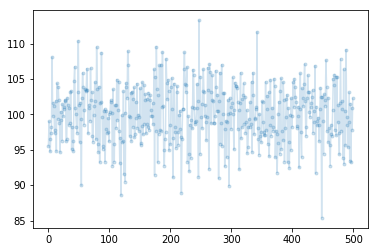

<Figure size 432x288 with 0 Axes>

In [9]:
%%time
i = randint(0,900)
home = "/export/home1/users/bssn/serna"
datadir = home+"/SyntheticData/syndat/"
Ft = load(datadir+"d"+str(i).zfill(4)+".npy")

Ftsh = Ft.shape
width,height,T = Ftsh  
print(Ftsh)
t = arange(Ftsh[-1])
figure()
plot(t,sum(sum(Ft,axis=0),axis=0),'.-',alpha=0.2)
figure()
#print("hello")

In [12]:
def get_random_time_segment(segment_frames,total_frames=12000):
    '''
    Gets a random time segment of duration segment_frames in a file
    with number of frames: total_frames
    '''
    
    segment_start = randint(0, high = total_frames-
                                   segment_frames)
    segment_end = segment_start + segment_frames
    
    return (segment_start, segment_end)

In [13]:
def is_overlapping(segment_time, previous_segments):
    '''
    This function checks if the time of a segment overlaps with the
    existing segments.
    '''
    s_start, s_end = segment_time
    
    overlap = False
    
    for prev_start, prev_end in previous_segments:
        if s_start <= prev_end and s_end >= prev_start:
            overlap = True
    
    return overlap

## Loading data set.

This is a big dataset, so we are going to divide it in 4000 samples for  training set and 100 dev_set and 100 test_set.

In [19]:
def readdata(Nsamples=800,magn=4,nframes = 500):

    X = zeros((Nsamples,width*magn,height*magn,nframes))
    Y = zeros((Nsamples,width*magn,height*magn))

    for i in range(Nsamples):
        xt = load(datadir+"d"+str(magn)+str(i).zfill(4)+".npy")
        yt = load(datadir+"o"+str(magn)+"_"+str(i).zfill(4)+".npy") 

        xt = xt/mean(xt.flatten())
        ymax = max(1,max(yt.flatten()))
        yt = yt/ymax

        ix = randint(20)
        iy = randint(20)
        X[i,:,:,:] = xt[ix:(ix+magn*width),iy:(iy+magn*height),:]
        Y[i,:,:] = yt[ix:(ix+magn*width),iy:(iy+magn*height)]
        #if i %50 == 0:
        #    print("Iteracion #",i)

    X = array(X)
    Y = array(Y)
    X = reshape(X,(X.shape[0],X.shape[1],X.shape[2],X.shape[3],1))
    Y = reshape(Y,(Y.shape[0],Y.shape[1],Y.shape[2],1,1))
    return(X,Y)

In [45]:
def readdatapart(N,Nsamples=800,magn=4,nframes = 500):

    X = zeros((Nsamples,width*magn,height*magn,nframes))
    Y = zeros((Nsamples,width*magn,height*magn))

    Nj = Nsamples//N
    if Nsamples%N!= 0:
        Nj += 1
    for i in range(N):
        xt = load(datadir+"d"+str(magn)+str(i).zfill(4)+".npy")
        yt = load(datadir+"o"+str(magn)+"_"+str(i).zfill(4)+".npy") 

        xt = xt/mean(xt.flatten())
        ymax = max(1,max(yt.flatten()))
        yt = yt/ymax

        for j in range(Nj):
            ix = randint(20)
            iy = randint(20)
            X[i*Nj+j,:,:,:] = xt[ix:(ix+magn*width),iy:(iy+magn*height),:]
            Y[i*Nj+j,:,:] = yt[ix:(ix+magn*width),iy:(iy+magn*height)]
        #if i %50 == 0:
        #    print("Iteracion #",i)

    X = array(X)
    Y = array(Y)
    X = reshape(X,(X.shape[0],X.shape[1],X.shape[2],X.shape[3],1))
    Y = reshape(Y,(Y.shape[0],Y.shape[1],Y.shape[2],1,1))
    return(X,Y)

In [14]:
from scipy.fftpack import fft2,fftshift,ifftshift,ifft2

def ftaugment(img,magn=2):
    sh = img.shape
    sh2 = (sh*(magn-1))
    sh2 = ((sh2[0])//2,(sh2[1])//2)
    fftim  = fftshift(fft2(img))
    fftim  =  pad(fftim,(sh2[0],sh2[1]),'constant')    
    imgn = real(ifft2(ifftshift(fftim)))
    return(imgn)

def ftvaugment(img,magn=2):
    sh = img.shape
    sh2 = array([sh[0],sh[1]])*(magn-1)
    sh2 = ((sh2[0])//2,(sh2[0])//2)
    fftim  = fftshift(fft2(img,axes=(0,1)),axes=(0,1))
    fftim  =  pad(fftim,(sh2[0],sh2[1]),'constant') 
    imgn = real(ifft2(ifftshift(fftim,axes=(0,1)),axes=(0,1)))
    imgn = imgn[:,:,sh2[0]:-sh2[0]]
    return(imgn)

In [ ]:
%%time
nframes = 500
magn=4

width = 5
height = 5

Nsamples = 800

X = zeros((Nsamples,width*magn,height*magn,nframes))
Y = zeros((Nsamples,width*magn,height*magn))

for i in range(Nsamples):
    xt = load(datadir+"d"+str(magn)+str(i).zfill(4)+".npy")
    yt = load(datadir+"o"+str(magn)+"_"+str(i).zfill(4)+".npy") 
    
    #print(xt.shape,yt.shape)
    
    xt = xt/mean(xt.flatten())
    #xt = ftvaugment(xt,magn)
    ymax = max(1,max(yt.flatten()))
    yt = yt/ymax

    #for j in range(1):
    #start,end = get_random_time_segment(nframes,T)
    ix = randint(20)
    iy = randint(20)
    X[i,:,:,:] = xt[ix:(ix+magn*width),iy:(iy+magn*height),:]
    Y[i,:,:] = yt[ix:(ix+magn*width),iy:(iy+magn*height)]
    if i %50 == 0:
        print("Iteracion #",i)
X = array(X)
Y = array(Y)
print(X.shape, Y.shape)
    

In [198]:
Xdev = []
Ydev = []
Xdev = zeros((100,width*magn,height*magn,nframes))
Ydev = zeros((100,width*magn,height*magn))
for i in range(Nsamples,Nsamples+100):
    xt = load(datadir+"d"+str(magn)+str(i).zfill(4)+".npy")
    yt = load(datadir+"o"+str(magn)+"_"+str(i).zfill(4)+".npy")
    xt = xt/mean(xt.flatten())
    #xt = ftvaugment(xt,magn)
    
    ymax = max(1,max(yt.flatten()))
    yt = yt/ymax
    #for j in range(1):
    #start,end = get_random_time_segment(nframes,T)
    ix = randint(20)
    iy = randint(20)
    Xdev[i-Nsamples,:,:,:] = xt[ix:(ix+magn*width),iy:(iy+magn*height),:]
    #Y.append(concatenate((yt[start:end],par[-1:])))
    #ytr = 0.05*ymax*randn(magn*width,magn*height)
    Ydev[i-Nsamples,:,:] = yt[ix:(ix+magn*width),iy:(iy+magn*height)]
Xdev = array(Xdev)
Ydev = array(Ydev)
Xdev = reshape(Xdev,(Xdev.shape[0],Xdev.shape[1],Xdev.shape[2],Xdev.shape[3],1))
Ydev = reshape(Ydev,(Ydev.shape[0],Ydev.shape[1],Ydev.shape[2],1,1))
print(Xdev.shape, Ydev.shape)

(100, 20, 20, 500, 1) (100, 20, 20, 1, 1)


In [199]:
Xdev.shape

(100, 20, 20, 500, 1)

719


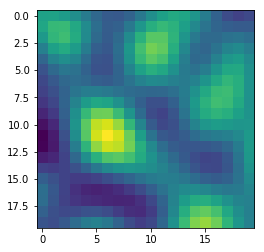

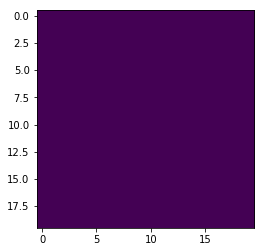

In [27]:
colors = array(['C0','C1'])
t = arange(1000)
# We plot some random pieces we chose to fit the network!

i = randint(0,X.shape[0])
imshow(squeeze(sum(X[i,:,:],axis=-1)))
figure()
imshow(squeeze(Y[i,:]))
print(i)

In [28]:
i

719

In [29]:
print(X.shape)
print(Y.shape)
print(Xdev.shape)
print(Ydev.shape)
width

(800, 20, 20, 500)
(800, 20, 20)
(100, 20, 20, 500)
(100, 20, 20)


5

## Definition of the network

Here, we define the neural network. We may start with just nframes logistic regressions?!

In [30]:
X = reshape(X,(X.shape[0],X.shape[1],X.shape[2],X.shape[3],1))
Y = reshape(Y,(Y.shape[0],Y.shape[1],Y.shape[2],1,1))

Xdev = reshape(Xdev,(Xdev.shape[0],Xdev.shape[1],Xdev.shape[2],Xdev.shape[3],1))
Ydev = reshape(Ydev,(Ydev.shape[0],Ydev.shape[1],Ydev.shape[2],1,1))

In [31]:
print(X.shape,Y.shape)

(800, 20, 20, 500, 1) (800, 20, 20, 1, 1)


In [32]:
def model(input_shape):
    '''
    Function used to create the model's graph in Keras
    
    Argument:
    -- input_shape. Shape of the model's input data (Keras conventions?!)
    
    Returns:
    -- model. Keras model instance
    '''

    X_input = Input(shape = input_shape)
    
    w,h,T,_ = input_shape
    # Layers

    X = X_input
    
    Xa = MaxPooling3D((2,2,40),strides=(1,1,5),padding="same")(X)
    Xb = AveragePooling3D((2,2,40),strides=(1,1,5),padding="same")(X)
    Xa2 =  Lambda(lambda x: x * x)(Xa)
    Xb2 = Lambda(lambda x: x * x)(Xb)
    Xa3 =  Lambda(lambda x: x **3)(Xa)
    Xb3 = Lambda(lambda x: x **3)(Xb)
    Xa4 =  Lambda(lambda x: x **4)(Xa)
    Xb4 = Lambda(lambda x: x **4)(Xb)

    X = Concatenate()([Xa,Xb,Xa2,Xb2,Xa3,Xb3,Xa4,Xb4])
    X = BatchNormalization()(X)   

    X = Dropout(0.3)(X)
    
    X = Conv3D(80,(4,4,8),strides=(1,1,3),padding="same")(X)
    X = Activation("relu")(X)
    X = BatchNormalization()(X)
    
    X = Dropout(0.3)(X)
    X = AveragePooling3D((4,4,20),strides=(1,1,3),padding="same")(X)
    X = BatchNormalization()(X)   
   
    X = Dropout(0.3)(X)
    X = Conv3D(40,(1,1,12),strides=(1,1,12),padding="valid")(X)
    X = Activation("relu")(X)
    X = BatchNormalization()(X) 

    
    #X = Dropout(0.3)(X)
    #X = MaxPooling3D((1,1,10),strides=(1,1,1),padding="same")(X)
    #X = Activation("relu")(X)
    #X = BatchNormalization()(X) 

    #X = Dropout(0.3)(X)
    #X = Conv3D(80,(1,1,10),strides=(1,1,2),padding="valid")(X)
    #X = Activation("relu")(X)
    #X = BatchNormalization()(X) 
    X = Dropout(0.3)(X)
    X = Dense(20,activation="relu")(X)
    X = BatchNormalization()(X) 

    X = Dropout(0.3)(X)
    X = Dense(5,activation="relu")(X)
    X = BatchNormalization()(X) 
    
    
    X = Dropout(0.3)(X)
    X = Dense(1,activation="relu")(X)

    # Defining the model
    
    model = Model(inputs = X_input, outputs = X)
    
    return model

In [33]:
model = model(input_shape = (magn*width,magn*height,nframes,1))

In [34]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 20, 20, 500,  0                                            
__________________________________________________________________________________________________
max_pooling3d_1 (MaxPooling3D)  (None, 20, 20, 100,  0           input_1[0][0]                    
__________________________________________________________________________________________________
average_pooling3d_1 (AveragePoo (None, 20, 20, 100,  0           input_1[0][0]                    
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 20, 20, 100,  0           max_pooling3d_1[0][0]            
__________________________________________________________________________________________________
lambda_2 (

### Fit the model!

In [35]:
from keras.optimizers import SGD

In [36]:
import keras.backend as K
def brutal_log(y_true,y_pred):
    '''Just another crossentropy'''
    ly = K.flatten(K.log(y_true+1e-8))
    ly2 = K.flatten(K.log(y_pred+1e-8))

    lyf = K.cast(K.flatten(ly> -100.0),dtype='float32')
    lyf2 = K.cast(K.flatten(ly2> -100.0),dtype='float32')
    lyf = lyf2*lyf
    out = K.mean((ly*lyf-ly2*lyf)**2)+200.0*K.mean(lyf2)
    return out

#Mendel ...
def MOC(y_true,y_pred):
    '''Just another crossentropy'''
    ly = K.sum(y_true*y_pred)
    ly2 = K.sum(y_pred*y_pred)
    ly3 = K.sum(y_true*y_true)
    out = ly/K.sqrt(ly2*ly3)
    return out

def MOCl(y_true,y_pred):
    '''Just another crossentropy'''
    ly = K.sum(y_true*y_pred)
    ly2 = K.sum(y_pred*y_pred)
    ly3 = K.sum(y_true*y_true)
    out = 1.0-ly/K.sqrt(ly2*ly3)
    return out
#Pearson Correlation
def PCC(y_true,y_pred):
    '''Just another crossentropy'''
    lt1 = y_true-K.mean(y_true)
    lt2 = y_pred-K.mean(y_pred)
    
    ly = K.sum(lt1*lt2)
    ly2 = K.sum(lt1*lt1)
    ly3 = K.sum(lt2*lt2)
    out = ly/K.sqrt(ly2*ly3)
    
    return out

def PCCl(y_true,y_pred):
    '''Just another crossentropy'''
    lt1 = y_true-K.mean(y_true)
    lt2 = y_pred-K.mean(y_pred)
    
    ly = K.sum(lt1*lt2)
    ly2 = K.sum(lt1*lt1)
    ly3 = K.sum(lt2*lt2)
    out = ly/K.sqrt(ly2*ly3)
    
    return 1.0-out




In [37]:
opt = Adam(lr=0.05, beta_1=0.7, beta_2=0.999, decay=0.001)
#opt = SGD(lr=100, decay=1e-6, momentum=1.9)

model.compile(loss=PCCl, optimizer=opt, metrics=[MOC])
#model.compile(loss='mean_squared_logarithmic_error', optimizer=opt, metrics=["accuracy"])
#model.compile(loss=brutal_log, optimizer=opt, metrics=["accuracy"])


In [59]:
history = {}
ih = 0

In [60]:
#Wsave = model.get_weights()
model.set_weights(Wsave)

In [61]:
import subprocess


In [63]:
%%time
X,Y = readdata()
print(X.shape)

(800, 20, 20, 500, 1)
CPU times: user 5.04 s, sys: 1.86 s, total: 6.9 s
Wall time: 6.89 s


In [64]:
print(X.shape)
print(Y.shape)

(800, 20, 20, 500, 1)
(800, 20, 20, 1, 1)


In [164]:

for j in range(20):

    prGen = subprocess.Popen('./generatemore4.sh')

    for i in range(20):
        ytr = 0.05*ymax*randn(Y.shape[0],Y.shape[1],Y.shape[2],1,1)
        Y1 = Y +ytr
        history[ih] = model.fit(X, Y1, batch_size = 100, epochs = 10)
        ih = ih+1

    model.save("deepsofi_x4_temp.h5")
    prGen.wait()
    X,Y = readdata()

prGen = subprocess.Popen('./generatemore4.sh')

for i in range(100):
    ytr = 0.05*ymax*randn(Y.shape[0],Y.shape[1],Y.shape[2],1,1)
    Y1 = Y +ytr
    history[ih] = model.fit(X, Y1, batch_size = 100, epochs = 10)
    ih = ih+1
print(ih)

Epoch 1/10
800/800 [==============================] - 8s 10ms/step - loss: 0.3990 - MOC: 0.6200
Epoch 2/10
800/800 [==============================] - 8s 10ms/step - loss: 0.3899 - MOC: 0.6288
Epoch 3/10
800/800 [==============================] - 8s 9ms/step - loss: 0.3815 - MOC: 0.6368
Epoch 4/10
800/800 [==============================] - 8s 10ms/step - loss: 0.3825 - MOC: 0.6359
Epoch 5/10
800/800 [==============================] - 8s 10ms/step - loss: 0.3814 - MOC: 0.6369
Epoch 6/10
800/800 [==============================] - 8s 10ms/step - loss: 0.3770 - MOC: 0.6410
Epoch 7/10
800/800 [==============================] - 8s 10ms/step - loss: 0.3788 - MOC: 0.6394
Epoch 8/10
800/800 [==============================] - 8s 10ms/step - loss: 0.3738 - MOC: 0.6440
Epoch 9/10
800/800 [==============================] - 8s 10ms/step - loss: 0.3765 - MOC: 0.6415
Epoch 10/10
800/800 [==============================] - 8s 10ms/step - loss: 0.3735 - MOC: 0.6443
Epoch 1/10
800/800 [====================

800/800 [==============================] - 8s 9ms/step - loss: 0.3444 - MOC: 0.6715
Epoch 7/10
800/800 [==============================] - 8s 10ms/step - loss: 0.3442 - MOC: 0.6717
Epoch 8/10
800/800 [==============================] - 8s 10ms/step - loss: 0.3410 - MOC: 0.6747
Epoch 9/10
800/800 [==============================] - 8s 10ms/step - loss: 0.3404 - MOC: 0.6754
Epoch 10/10
800/800 [==============================] - 8s 10ms/step - loss: 0.3399 - MOC: 0.6759
Epoch 1/10
800/800 [==============================] - 8s 9ms/step - loss: 0.3375 - MOC: 0.6783
Epoch 2/10
800/800 [==============================] - 8s 10ms/step - loss: 0.3374 - MOC: 0.6784
Epoch 3/10
800/800 [==============================] - 8s 9ms/step - loss: 0.3407 - MOC: 0.6752
Epoch 4/10
800/800 [==============================] - 8s 9ms/step - loss: 0.3388 - MOC: 0.6770
Epoch 5/10
800/800 [==============================] - 8s 10ms/step - loss: 0.3389 - MOC: 0.6769
Epoch 6/10
800/800 [==============================] - 

800/800 [==============================] - 8s 10ms/step - loss: 0.3201 - MOC: 0.6943
Epoch 2/10
800/800 [==============================] - 8s 9ms/step - loss: 0.3157 - MOC: 0.6985
Epoch 3/10
800/800 [==============================] - 8s 9ms/step - loss: 0.3174 - MOC: 0.6969
Epoch 4/10
800/800 [==============================] - 8s 9ms/step - loss: 0.3192 - MOC: 0.6951
Epoch 5/10
800/800 [==============================] - 8s 10ms/step - loss: 0.3170 - MOC: 0.6971
Epoch 6/10
800/800 [==============================] - 7s 9ms/step - loss: 0.3162 - MOC: 0.6980
Epoch 7/10
800/800 [==============================] - 8s 10ms/step - loss: 0.3147 - MOC: 0.6996
Epoch 8/10
800/800 [==============================] - 8s 10ms/step - loss: 0.3164 - MOC: 0.6978
Epoch 9/10
800/800 [==============================] - 8s 10ms/step - loss: 0.3160 - MOC: 0.6983
Epoch 10/10
800/800 [==============================] - 8s 10ms/step - loss: 0.3127 - MOC: 0.7013
Epoch 1/10
800/800 [==============================] - 

800/800 [==============================] - 7s 9ms/step - loss: 0.3514 - MOC: 0.6630
Epoch 8/10
800/800 [==============================] - 8s 9ms/step - loss: 0.3542 - MOC: 0.6601
Epoch 9/10
800/800 [==============================] - 7s 9ms/step - loss: 0.3531 - MOC: 0.6610
Epoch 10/10
800/800 [==============================] - 7s 9ms/step - loss: 0.3516 - MOC: 0.6627
Epoch 1/10
800/800 [==============================] - 7s 9ms/step - loss: 0.3501 - MOC: 0.6641
Epoch 2/10
800/800 [==============================] - 7s 9ms/step - loss: 0.3509 - MOC: 0.6632
Epoch 3/10
800/800 [==============================] - 7s 9ms/step - loss: 0.3470 - MOC: 0.6670
Epoch 4/10
800/800 [==============================] - 7s 9ms/step - loss: 0.3535 - MOC: 0.6607
Epoch 5/10
800/800 [==============================] - 7s 9ms/step - loss: 0.3506 - MOC: 0.6635
Epoch 6/10
800/800 [==============================] - 7s 9ms/step - loss: 0.3480 - MOC: 0.6661
Epoch 7/10
800/800 [==============================] - 7s 9ms

800/800 [==============================] - 7s 9ms/step - loss: 0.3261 - MOC: 0.6870
Epoch 4/10
800/800 [==============================] - 8s 9ms/step - loss: 0.3277 - MOC: 0.6854
Epoch 5/10
800/800 [==============================] - 7s 9ms/step - loss: 0.3261 - MOC: 0.6869
Epoch 6/10
800/800 [==============================] - 7s 9ms/step - loss: 0.3283 - MOC: 0.6848
Epoch 7/10
800/800 [==============================] - 7s 9ms/step - loss: 0.3261 - MOC: 0.6869
Epoch 8/10
800/800 [==============================] - 7s 9ms/step - loss: 0.3287 - MOC: 0.6844
Epoch 9/10
800/800 [==============================] - 7s 9ms/step - loss: 0.3264 - MOC: 0.6866
Epoch 10/10
800/800 [==============================] - 7s 9ms/step - loss: 0.3289 - MOC: 0.6841
Epoch 1/10
800/800 [==============================] - 7s 9ms/step - loss: 0.3247 - MOC: 0.6882
Epoch 2/10
800/800 [==============================] - 8s 9ms/step - loss: 0.3252 - MOC: 0.6875
Epoch 3/10
800/800 [==============================] - 7s 9ms

800/800 [==============================] - 8s 10ms/step - loss: 0.3627 - MOC: 0.6531
Epoch 10/10
800/800 [==============================] - 8s 10ms/step - loss: 0.3644 - MOC: 0.6516
Epoch 1/10
800/800 [==============================] - 8s 10ms/step - loss: 0.3629 - MOC: 0.6528
Epoch 2/10
800/800 [==============================] - 8s 10ms/step - loss: 0.3619 - MOC: 0.6538
Epoch 3/10
800/800 [==============================] - 8s 10ms/step - loss: 0.3618 - MOC: 0.6540
Epoch 4/10
800/800 [==============================] - 8s 10ms/step - loss: 0.3621 - MOC: 0.6536
Epoch 5/10
800/800 [==============================] - 8s 10ms/step - loss: 0.3596 - MOC: 0.6559
Epoch 6/10
800/800 [==============================] - 8s 10ms/step - loss: 0.3588 - MOC: 0.6568
Epoch 7/10
800/800 [==============================] - 8s 10ms/step - loss: 0.3605 - MOC: 0.6551
Epoch 8/10
800/800 [==============================] - 8s 10ms/step - loss: 0.3583 - MOC: 0.6572
Epoch 9/10
800/800 [==============================

800/800 [==============================] - 8s 10ms/step - loss: 0.3353 - MOC: 0.6787
Epoch 5/10
800/800 [==============================] - 7s 9ms/step - loss: 0.3314 - MOC: 0.6827
Epoch 6/10
800/800 [==============================] - 8s 10ms/step - loss: 0.3364 - MOC: 0.6778
Epoch 7/10
800/800 [==============================] - 8s 10ms/step - loss: 0.3389 - MOC: 0.6752
Epoch 8/10
800/800 [==============================] - 8s 10ms/step - loss: 0.3344 - MOC: 0.6798
Epoch 9/10
800/800 [==============================] - 8s 10ms/step - loss: 0.3345 - MOC: 0.6795
Epoch 10/10
800/800 [==============================] - 7s 9ms/step - loss: 0.3353 - MOC: 0.6787
Epoch 1/10
800/800 [==============================] - 7s 9ms/step - loss: 0.3305 - MOC: 0.6833
Epoch 2/10
800/800 [==============================] - 8s 10ms/step - loss: 0.3311 - MOC: 0.6827
Epoch 3/10
800/800 [==============================] - 8s 9ms/step - loss: 0.3291 - MOC: 0.6846
Epoch 4/10
800/800 [==============================] - 

800/800 [==============================] - 8s 10ms/step - loss: 0.3155 - MOC: 0.6977
Epoch 10/10
800/800 [==============================] - 8s 9ms/step - loss: 0.3171 - MOC: 0.6960
Epoch 1/10
800/800 [==============================] - 8s 10ms/step - loss: 0.3968 - MOC: 0.6208
Epoch 2/10
800/800 [==============================] - 8s 10ms/step - loss: 0.3854 - MOC: 0.6319
Epoch 3/10
800/800 [==============================] - 8s 9ms/step - loss: 0.3813 - MOC: 0.6358
Epoch 4/10
800/800 [==============================] - 8s 10ms/step - loss: 0.3808 - MOC: 0.6361
Epoch 5/10
800/800 [==============================] - 8s 10ms/step - loss: 0.3771 - MOC: 0.6396
Epoch 6/10
800/800 [==============================] - 8s 10ms/step - loss: 0.3753 - MOC: 0.6414
Epoch 7/10
800/800 [==============================] - 8s 10ms/step - loss: 0.3751 - MOC: 0.6416
Epoch 8/10
800/800 [==============================] - 8s 10ms/step - loss: 0.3751 - MOC: 0.6415
Epoch 9/10
800/800 [==============================] 

800/800 [==============================] - 8s 10ms/step - loss: 0.3429 - MOC: 0.6720
Epoch 5/10
800/800 [==============================] - 8s 10ms/step - loss: 0.3423 - MOC: 0.6725
Epoch 6/10
800/800 [==============================] - 8s 10ms/step - loss: 0.3430 - MOC: 0.6717
Epoch 7/10
800/800 [==============================] - 8s 10ms/step - loss: 0.3425 - MOC: 0.6723
Epoch 8/10
800/800 [==============================] - 8s 10ms/step - loss: 0.3427 - MOC: 0.6720
Epoch 9/10
800/800 [==============================] - 8s 10ms/step - loss: 0.3411 - MOC: 0.6736
Epoch 10/10
800/800 [==============================] - 8s 10ms/step - loss: 0.3422 - MOC: 0.6726
Epoch 1/10
800/800 [==============================] - 7s 9ms/step - loss: 0.3418 - MOC: 0.6728
Epoch 2/10
800/800 [==============================] - 8s 10ms/step - loss: 0.3423 - MOC: 0.6723
Epoch 3/10
800/800 [==============================] - 8s 10ms/step - loss: 0.3434 - MOC: 0.6711
Epoch 4/10
800/800 [==============================]

800/800 [==============================] - 8s 10ms/step - loss: 0.3182 - MOC: 0.6954
Epoch 10/10
800/800 [==============================] - 8s 10ms/step - loss: 0.3216 - MOC: 0.6920
Epoch 1/10
800/800 [==============================] - 8s 10ms/step - loss: 0.3202 - MOC: 0.6933
Epoch 2/10
800/800 [==============================] - 8s 10ms/step - loss: 0.3241 - MOC: 0.6894
Epoch 3/10
800/800 [==============================] - 8s 10ms/step - loss: 0.3222 - MOC: 0.6914
Epoch 4/10
800/800 [==============================] - 8s 10ms/step - loss: 0.3195 - MOC: 0.6940
Epoch 5/10
800/800 [==============================] - 8s 10ms/step - loss: 0.3217 - MOC: 0.6918
Epoch 6/10
800/800 [==============================] - 8s 10ms/step - loss: 0.3206 - MOC: 0.6930
Epoch 7/10
800/800 [==============================] - 8s 10ms/step - loss: 0.3186 - MOC: 0.6949
Epoch 8/10
800/800 [==============================] - 8s 10ms/step - loss: 0.3203 - MOC: 0.6932
Epoch 9/10
800/800 [==============================

800/800 [==============================] - 7s 9ms/step - loss: 0.3527 - MOC: 0.6629
Epoch 5/10
800/800 [==============================] - 7s 9ms/step - loss: 0.3542 - MOC: 0.6613
Epoch 6/10
800/800 [==============================] - 7s 9ms/step - loss: 0.3505 - MOC: 0.6650
Epoch 7/10
800/800 [==============================] - 7s 9ms/step - loss: 0.3476 - MOC: 0.6678
Epoch 8/10
800/800 [==============================] - 7s 9ms/step - loss: 0.3512 - MOC: 0.6644
Epoch 9/10
800/800 [==============================] - 7s 9ms/step - loss: 0.3488 - MOC: 0.6665
Epoch 10/10
800/800 [==============================] - 7s 9ms/step - loss: 0.3482 - MOC: 0.6671
Epoch 1/10
800/800 [==============================] - 7s 9ms/step - loss: 0.3508 - MOC: 0.6652
Epoch 2/10
800/800 [==============================] - 7s 9ms/step - loss: 0.3505 - MOC: 0.6656
Epoch 3/10
800/800 [==============================] - 7s 9ms/step - loss: 0.3460 - MOC: 0.6698
Epoch 4/10
800/800 [==============================] - 7s 9ms

800/800 [==============================] - 7s 9ms/step - loss: 0.3288 - MOC: 0.6858
Epoch 1/10
800/800 [==============================] - 7s 9ms/step - loss: 0.3285 - MOC: 0.6862
Epoch 2/10
800/800 [==============================] - 8s 10ms/step - loss: 0.3270 - MOC: 0.6876
Epoch 3/10
800/800 [==============================] - 8s 9ms/step - loss: 0.3243 - MOC: 0.6902
Epoch 4/10
800/800 [==============================] - 8s 9ms/step - loss: 0.3306 - MOC: 0.6842
Epoch 5/10
800/800 [==============================] - 8s 10ms/step - loss: 0.3310 - MOC: 0.6837
Epoch 6/10
800/800 [==============================] - 8s 9ms/step - loss: 0.3251 - MOC: 0.6893
Epoch 7/10
800/800 [==============================] - 8s 10ms/step - loss: 0.3266 - MOC: 0.6879
Epoch 8/10
800/800 [==============================] - 7s 9ms/step - loss: 0.3278 - MOC: 0.6867
Epoch 9/10
800/800 [==============================] - 7s 9ms/step - loss: 0.3294 - MOC: 0.6853
Epoch 10/10
800/800 [==============================] - 7s 

800/800 [==============================] - 7s 9ms/step - loss: 0.3468 - MOC: 0.6697
Epoch 7/10
800/800 [==============================] - 7s 9ms/step - loss: 0.3465 - MOC: 0.6699
Epoch 8/10
800/800 [==============================] - 7s 9ms/step - loss: 0.3473 - MOC: 0.6691
Epoch 9/10
800/800 [==============================] - 7s 9ms/step - loss: 0.3492 - MOC: 0.6672
Epoch 10/10
800/800 [==============================] - 8s 10ms/step - loss: 0.3469 - MOC: 0.6696
Epoch 1/10
800/800 [==============================] - 8s 9ms/step - loss: 0.3439 - MOC: 0.6725
Epoch 2/10
800/800 [==============================] - 7s 9ms/step - loss: 0.3448 - MOC: 0.6717
Epoch 3/10
800/800 [==============================] - 7s 9ms/step - loss: 0.3470 - MOC: 0.6695
Epoch 4/10
800/800 [==============================] - 7s 9ms/step - loss: 0.3436 - MOC: 0.6729
Epoch 5/10
800/800 [==============================] - 7s 9ms/step - loss: 0.3432 - MOC: 0.6731
Epoch 6/10
800/800 [==============================] - 7s 9m

800/800 [==============================] - 8s 9ms/step - loss: 0.3265 - MOC: 0.6886
Epoch 3/10
800/800 [==============================] - 8s 9ms/step - loss: 0.3242 - MOC: 0.6909
Epoch 4/10
800/800 [==============================] - 8s 9ms/step - loss: 0.3263 - MOC: 0.6887
Epoch 5/10
800/800 [==============================] - 7s 9ms/step - loss: 0.3252 - MOC: 0.6898
Epoch 6/10
800/800 [==============================] - 7s 9ms/step - loss: 0.3228 - MOC: 0.6922
Epoch 7/10
800/800 [==============================] - 7s 9ms/step - loss: 0.3210 - MOC: 0.6938
Epoch 8/10
800/800 [==============================] - 7s 9ms/step - loss: 0.3232 - MOC: 0.6917
Epoch 9/10
800/800 [==============================] - 7s 9ms/step - loss: 0.3215 - MOC: 0.6934
Epoch 10/10
800/800 [==============================] - 7s 9ms/step - loss: 0.3257 - MOC: 0.6893
Epoch 1/10
800/800 [==============================] - 7s 9ms/step - loss: 0.3243 - MOC: 0.6908
Epoch 2/10
800/800 [==============================] - 7s 9ms

800/800 [==============================] - 7s 9ms/step - loss: 0.3105 - MOC: 0.7038
Epoch 9/10
800/800 [==============================] - 7s 9ms/step - loss: 0.3094 - MOC: 0.7048
Epoch 10/10
800/800 [==============================] - 7s 9ms/step - loss: 0.3093 - MOC: 0.7049
Epoch 1/10
800/800 [==============================] - 7s 9ms/step - loss: 0.3883 - MOC: 0.6294
Epoch 2/10
800/800 [==============================] - 7s 9ms/step - loss: 0.3795 - MOC: 0.6378
Epoch 3/10
800/800 [==============================] - 7s 9ms/step - loss: 0.3754 - MOC: 0.6418
Epoch 4/10
800/800 [==============================] - 8s 9ms/step - loss: 0.3738 - MOC: 0.6433
Epoch 5/10
800/800 [==============================] - 8s 10ms/step - loss: 0.3738 - MOC: 0.6433
Epoch 6/10
800/800 [==============================] - 7s 9ms/step - loss: 0.3721 - MOC: 0.6448
Epoch 7/10
800/800 [==============================] - 7s 9ms/step - loss: 0.3682 - MOC: 0.6487
Epoch 8/10
800/800 [==============================] - 7s 9m

800/800 [==============================] - 7s 9ms/step - loss: 0.3451 - MOC: 0.6704
Epoch 5/10
800/800 [==============================] - 7s 9ms/step - loss: 0.3478 - MOC: 0.6677
Epoch 6/10
800/800 [==============================] - 7s 9ms/step - loss: 0.3459 - MOC: 0.6696
Epoch 7/10
800/800 [==============================] - 7s 9ms/step - loss: 0.3435 - MOC: 0.6720
Epoch 8/10
800/800 [==============================] - 8s 9ms/step - loss: 0.3457 - MOC: 0.6698
Epoch 9/10
800/800 [==============================] - 7s 9ms/step - loss: 0.3463 - MOC: 0.6692
Epoch 10/10
800/800 [==============================] - 8s 9ms/step - loss: 0.3443 - MOC: 0.6712
Epoch 1/10
800/800 [==============================] - 7s 9ms/step - loss: 0.3421 - MOC: 0.6729
Epoch 2/10
800/800 [==============================] - 7s 9ms/step - loss: 0.3418 - MOC: 0.6733
Epoch 3/10
800/800 [==============================] - 8s 9ms/step - loss: 0.3434 - MOC: 0.6718
Epoch 4/10
800/800 [==============================] - 7s 9ms

800/800 [==============================] - 7s 9ms/step - loss: 0.3262 - MOC: 0.6882
Epoch 1/10
800/800 [==============================] - 7s 9ms/step - loss: 0.3269 - MOC: 0.6875
Epoch 2/10
800/800 [==============================] - 7s 9ms/step - loss: 0.3271 - MOC: 0.6872
Epoch 3/10
800/800 [==============================] - 8s 9ms/step - loss: 0.3269 - MOC: 0.6873
Epoch 4/10
800/800 [==============================] - 7s 9ms/step - loss: 0.3249 - MOC: 0.6892
Epoch 5/10
800/800 [==============================] - 7s 9ms/step - loss: 0.3245 - MOC: 0.6897
Epoch 6/10
800/800 [==============================] - 7s 9ms/step - loss: 0.3262 - MOC: 0.6881
Epoch 7/10
800/800 [==============================] - 7s 9ms/step - loss: 0.3227 - MOC: 0.6914
Epoch 8/10
800/800 [==============================] - 7s 9ms/step - loss: 0.3247 - MOC: 0.6895
Epoch 9/10
800/800 [==============================] - 7s 9ms/step - loss: 0.3252 - MOC: 0.6890
Epoch 10/10
800/800 [==============================] - 7s 9ms

800/800 [==============================] - 7s 9ms/step - loss: 0.3614 - MOC: 0.6537
Epoch 7/10
800/800 [==============================] - 7s 9ms/step - loss: 0.3631 - MOC: 0.6520
Epoch 8/10
800/800 [==============================] - 7s 9ms/step - loss: 0.3645 - MOC: 0.6506
Epoch 9/10
800/800 [==============================] - 7s 9ms/step - loss: 0.3608 - MOC: 0.6542
Epoch 10/10
800/800 [==============================] - 7s 9ms/step - loss: 0.3597 - MOC: 0.6553
Epoch 1/10
800/800 [==============================] - 8s 9ms/step - loss: 0.3638 - MOC: 0.6514
Epoch 2/10
800/800 [==============================] - 8s 9ms/step - loss: 0.3608 - MOC: 0.6542
Epoch 3/10
800/800 [==============================] - 7s 9ms/step - loss: 0.3593 - MOC: 0.6556
Epoch 4/10
800/800 [==============================] - 7s 9ms/step - loss: 0.3603 - MOC: 0.6548
Epoch 5/10
800/800 [==============================] - 8s 9ms/step - loss: 0.3599 - MOC: 0.6550
Epoch 6/10
800/800 [==============================] - 8s 9ms

800/800 [==============================] - 7s 9ms/step - loss: 0.3383 - MOC: 0.6757
Epoch 3/10
800/800 [==============================] - 8s 9ms/step - loss: 0.3373 - MOC: 0.6767
Epoch 4/10
800/800 [==============================] - 7s 9ms/step - loss: 0.3362 - MOC: 0.6777
Epoch 5/10
800/800 [==============================] - 7s 9ms/step - loss: 0.3395 - MOC: 0.6745
Epoch 6/10
800/800 [==============================] - 7s 9ms/step - loss: 0.3393 - MOC: 0.6748
Epoch 7/10
800/800 [==============================] - 7s 9ms/step - loss: 0.3388 - MOC: 0.6751
Epoch 8/10
800/800 [==============================] - 7s 9ms/step - loss: 0.3386 - MOC: 0.6753
Epoch 9/10
800/800 [==============================] - 7s 9ms/step - loss: 0.3391 - MOC: 0.6747
Epoch 10/10
800/800 [==============================] - 8s 9ms/step - loss: 0.3386 - MOC: 0.6754
Epoch 1/10
800/800 [==============================] - 8s 9ms/step - loss: 0.3325 - MOC: 0.6809
Epoch 2/10
800/800 [==============================] - 7s 9ms

800/800 [==============================] - 7s 9ms/step - loss: 0.3705 - MOC: 0.6473
Epoch 9/10
800/800 [==============================] - 7s 9ms/step - loss: 0.3690 - MOC: 0.6488
Epoch 10/10
800/800 [==============================] - 7s 9ms/step - loss: 0.3671 - MOC: 0.6507
Epoch 1/10
800/800 [==============================] - 7s 9ms/step - loss: 0.3679 - MOC: 0.6500
Epoch 2/10
800/800 [==============================] - 7s 9ms/step - loss: 0.3695 - MOC: 0.6485
Epoch 3/10
800/800 [==============================] - 7s 9ms/step - loss: 0.3695 - MOC: 0.6485
Epoch 4/10
800/800 [==============================] - 8s 9ms/step - loss: 0.3711 - MOC: 0.6469
Epoch 5/10
800/800 [==============================] - 8s 9ms/step - loss: 0.3684 - MOC: 0.6494
Epoch 6/10
800/800 [==============================] - 8s 9ms/step - loss: 0.3709 - MOC: 0.6471
Epoch 7/10
800/800 [==============================] - 7s 9ms/step - loss: 0.3668 - MOC: 0.6510
Epoch 8/10
800/800 [==============================] - 7s 9ms

800/800 [==============================] - 7s 9ms/step - loss: 0.3499 - MOC: 0.6665
Epoch 5/10
800/800 [==============================] - 7s 9ms/step - loss: 0.3476 - MOC: 0.6688
Epoch 6/10
800/800 [==============================] - 7s 9ms/step - loss: 0.3477 - MOC: 0.6687
Epoch 7/10
800/800 [==============================] - 7s 9ms/step - loss: 0.3461 - MOC: 0.6702
Epoch 8/10
800/800 [==============================] - 7s 9ms/step - loss: 0.3454 - MOC: 0.6708
Epoch 9/10
800/800 [==============================] - 7s 9ms/step - loss: 0.3475 - MOC: 0.6688
Epoch 10/10
800/800 [==============================] - 8s 9ms/step - loss: 0.3439 - MOC: 0.6723
Epoch 1/10
800/800 [==============================] - 7s 9ms/step - loss: 0.3493 - MOC: 0.6670
Epoch 2/10
800/800 [==============================] - 7s 9ms/step - loss: 0.3475 - MOC: 0.6688
Epoch 3/10
800/800 [==============================] - 8s 10ms/step - loss: 0.3469 - MOC: 0.6693
Epoch 4/10
800/800 [==============================] - 8s 10

800/800 [==============================] - 7s 9ms/step - loss: 0.3319 - MOC: 0.6834
Epoch 1/10
800/800 [==============================] - 8s 10ms/step - loss: 0.3954 - MOC: 0.6225
Epoch 2/10
800/800 [==============================] - 8s 10ms/step - loss: 0.3871 - MOC: 0.6305
Epoch 3/10
800/800 [==============================] - 7s 9ms/step - loss: 0.3870 - MOC: 0.6303
Epoch 4/10
800/800 [==============================] - 7s 9ms/step - loss: 0.3808 - MOC: 0.6362
Epoch 5/10
800/800 [==============================] - 7s 9ms/step - loss: 0.3769 - MOC: 0.6400
Epoch 6/10
800/800 [==============================] - 7s 9ms/step - loss: 0.3786 - MOC: 0.6383
Epoch 7/10
800/800 [==============================] - 8s 10ms/step - loss: 0.3775 - MOC: 0.6395
Epoch 8/10
800/800 [==============================] - 8s 10ms/step - loss: 0.3750 - MOC: 0.6418
Epoch 9/10
800/800 [==============================] - 8s 10ms/step - loss: 0.3754 - MOC: 0.6414
Epoch 10/10
800/800 [==============================] - 8

800/800 [==============================] - 8s 10ms/step - loss: 0.3496 - MOC: 0.6658
Epoch 6/10
800/800 [==============================] - 8s 10ms/step - loss: 0.3500 - MOC: 0.6654
Epoch 7/10
800/800 [==============================] - 8s 10ms/step - loss: 0.3476 - MOC: 0.6677
Epoch 8/10
800/800 [==============================] - 8s 10ms/step - loss: 0.3493 - MOC: 0.6661
Epoch 9/10
800/800 [==============================] - 8s 10ms/step - loss: 0.3490 - MOC: 0.6663
Epoch 10/10
800/800 [==============================] - 8s 10ms/step - loss: 0.3465 - MOC: 0.6688
Epoch 1/10
800/800 [==============================] - 8s 10ms/step - loss: 0.3491 - MOC: 0.6664
Epoch 2/10
800/800 [==============================] - 8s 10ms/step - loss: 0.3485 - MOC: 0.6670
Epoch 3/10
800/800 [==============================] - 8s 10ms/step - loss: 0.3477 - MOC: 0.6678
Epoch 4/10
800/800 [==============================] - 8s 10ms/step - loss: 0.3484 - MOC: 0.6671
Epoch 5/10
800/800 [==============================

800/800 [==============================] - 8s 10ms/step - loss: 0.3290 - MOC: 0.6854
Epoch 1/10
800/800 [==============================] - 8s 9ms/step - loss: 0.3293 - MOC: 0.6849
Epoch 2/10
800/800 [==============================] - 8s 10ms/step - loss: 0.3303 - MOC: 0.6841
Epoch 3/10
800/800 [==============================] - 8s 10ms/step - loss: 0.3313 - MOC: 0.6830
Epoch 4/10
800/800 [==============================] - 8s 10ms/step - loss: 0.3296 - MOC: 0.6846
Epoch 5/10
800/800 [==============================] - 8s 10ms/step - loss: 0.3282 - MOC: 0.6861
Epoch 6/10
800/800 [==============================] - 8s 10ms/step - loss: 0.3285 - MOC: 0.6858
Epoch 7/10
800/800 [==============================] - 8s 9ms/step - loss: 0.3281 - MOC: 0.6861
Epoch 8/10
800/800 [==============================] - 8s 10ms/step - loss: 0.3272 - MOC: 0.6868
Epoch 9/10
800/800 [==============================] - 8s 10ms/step - loss: 0.3282 - MOC: 0.6861
Epoch 10/10
800/800 [==============================] 

800/800 [==============================] - 8s 9ms/step - loss: 0.3560 - MOC: 0.6598
Epoch 7/10
800/800 [==============================] - 7s 9ms/step - loss: 0.3580 - MOC: 0.6579
Epoch 8/10
800/800 [==============================] - 7s 9ms/step - loss: 0.3562 - MOC: 0.6595
Epoch 9/10
800/800 [==============================] - 7s 9ms/step - loss: 0.3566 - MOC: 0.6591
Epoch 10/10
800/800 [==============================] - 7s 9ms/step - loss: 0.3556 - MOC: 0.6602
Epoch 1/10
800/800 [==============================] - 7s 9ms/step - loss: 0.3571 - MOC: 0.6589
Epoch 2/10
800/800 [==============================] - 7s 9ms/step - loss: 0.3573 - MOC: 0.6587
Epoch 3/10
800/800 [==============================] - 7s 9ms/step - loss: 0.3538 - MOC: 0.6622
Epoch 4/10
800/800 [==============================] - 7s 9ms/step - loss: 0.3603 - MOC: 0.6557
Epoch 5/10
800/800 [==============================] - 7s 9ms/step - loss: 0.3553 - MOC: 0.6607
Epoch 6/10
800/800 [==============================] - 8s 9ms

800/800 [==============================] - 8s 10ms/step - loss: 0.3414 - MOC: 0.6737
Epoch 3/10
800/800 [==============================] - 8s 9ms/step - loss: 0.3386 - MOC: 0.6763
Epoch 4/10
800/800 [==============================] - 8s 9ms/step - loss: 0.3396 - MOC: 0.6753
Epoch 5/10
800/800 [==============================] - 8s 9ms/step - loss: 0.3398 - MOC: 0.6752
Epoch 6/10
800/800 [==============================] - 7s 9ms/step - loss: 0.3393 - MOC: 0.6757
Epoch 7/10
800/800 [==============================] - 8s 9ms/step - loss: 0.3396 - MOC: 0.6752
Epoch 8/10
800/800 [==============================] - 8s 9ms/step - loss: 0.3420 - MOC: 0.6730
Epoch 9/10
800/800 [==============================] - 8s 9ms/step - loss: 0.3406 - MOC: 0.6743
Epoch 10/10
800/800 [==============================] - 7s 9ms/step - loss: 0.3386 - MOC: 0.6763
Epoch 1/10
800/800 [==============================] - 7s 9ms/step - loss: 0.3370 - MOC: 0.6780
Epoch 2/10
800/800 [==============================] - 7s 9m

800/800 [==============================] - 7s 9ms/step - loss: 0.3745 - MOC: 0.6410
Epoch 9/10
800/800 [==============================] - 7s 9ms/step - loss: 0.3736 - MOC: 0.6419
Epoch 10/10
800/800 [==============================] - 8s 9ms/step - loss: 0.3741 - MOC: 0.6414
Epoch 1/10
800/800 [==============================] - 7s 9ms/step - loss: 0.3739 - MOC: 0.6418
Epoch 2/10
800/800 [==============================] - 7s 9ms/step - loss: 0.3723 - MOC: 0.6434
Epoch 3/10
800/800 [==============================] - 7s 9ms/step - loss: 0.3728 - MOC: 0.6429
Epoch 4/10
800/800 [==============================] - 8s 9ms/step - loss: 0.3730 - MOC: 0.6427
Epoch 5/10
800/800 [==============================] - 7s 9ms/step - loss: 0.3730 - MOC: 0.6426
Epoch 6/10
800/800 [==============================] - 7s 9ms/step - loss: 0.3724 - MOC: 0.6433
Epoch 7/10
800/800 [==============================] - 7s 9ms/step - loss: 0.3744 - MOC: 0.6413
Epoch 8/10
800/800 [==============================] - 7s 9ms

800/800 [==============================] - 8s 10ms/step - loss: 0.3499 - MOC: 0.6644
Epoch 5/10
800/800 [==============================] - 7s 9ms/step - loss: 0.3510 - MOC: 0.6633
Epoch 6/10
800/800 [==============================] - 7s 9ms/step - loss: 0.3494 - MOC: 0.6649
Epoch 7/10
800/800 [==============================] - 7s 9ms/step - loss: 0.3501 - MOC: 0.6642
Epoch 8/10
800/800 [==============================] - 7s 9ms/step - loss: 0.3543 - MOC: 0.6600
Epoch 9/10
800/800 [==============================] - 7s 9ms/step - loss: 0.3500 - MOC: 0.6643
Epoch 10/10
800/800 [==============================] - 7s 9ms/step - loss: 0.3501 - MOC: 0.6642
Epoch 1/10
800/800 [==============================] - 7s 9ms/step - loss: 0.3512 - MOC: 0.6629
Epoch 2/10
800/800 [==============================] - 7s 9ms/step - loss: 0.3514 - MOC: 0.6627
Epoch 3/10
800/800 [==============================] - 7s 9ms/step - loss: 0.3527 - MOC: 0.6616
Epoch 4/10
800/800 [==============================] - 8s 9m

800/800 [==============================] - 8s 10ms/step - loss: 0.3361 - MOC: 0.6774
Epoch 1/10
800/800 [==============================] - 7s 9ms/step - loss: 0.4037 - MOC: 0.6136
Epoch 2/10
800/800 [==============================] - 7s 9ms/step - loss: 0.3912 - MOC: 0.6259
Epoch 3/10
800/800 [==============================] - 8s 9ms/step - loss: 0.3884 - MOC: 0.6286
Epoch 4/10
800/800 [==============================] - 8s 9ms/step - loss: 0.3845 - MOC: 0.6322
Epoch 5/10
800/800 [==============================] - 7s 9ms/step - loss: 0.3846 - MOC: 0.6322
Epoch 6/10
800/800 [==============================] - 8s 10ms/step - loss: 0.3830 - MOC: 0.6336
Epoch 7/10
800/800 [==============================] - 8s 9ms/step - loss: 0.3822 - MOC: 0.6344
Epoch 8/10
800/800 [==============================] - 7s 9ms/step - loss: 0.3817 - MOC: 0.6348
Epoch 9/10
800/800 [==============================] - 7s 9ms/step - loss: 0.3768 - MOC: 0.6395
Epoch 10/10
800/800 [==============================] - 7s 9

800/800 [==============================] - 7s 9ms/step - loss: 0.3583 - MOC: 0.6568
Epoch 7/10
800/800 [==============================] - 7s 9ms/step - loss: 0.3575 - MOC: 0.6577
Epoch 8/10
800/800 [==============================] - 7s 9ms/step - loss: 0.3602 - MOC: 0.6550
Epoch 9/10
800/800 [==============================] - 7s 9ms/step - loss: 0.3612 - MOC: 0.6540
Epoch 10/10
800/800 [==============================] - 7s 9ms/step - loss: 0.3570 - MOC: 0.6581
Epoch 1/10
800/800 [==============================] - 7s 9ms/step - loss: 0.3575 - MOC: 0.6575
Epoch 2/10
800/800 [==============================] - 7s 9ms/step - loss: 0.3562 - MOC: 0.6588
Epoch 3/10
800/800 [==============================] - 7s 9ms/step - loss: 0.3584 - MOC: 0.6566
Epoch 4/10
800/800 [==============================] - 8s 9ms/step - loss: 0.3577 - MOC: 0.6573
Epoch 5/10
800/800 [==============================] - 8s 9ms/step - loss: 0.3582 - MOC: 0.6569
Epoch 6/10
800/800 [==============================] - 8s 9ms

800/800 [==============================] - 7s 9ms/step - loss: 0.3415 - MOC: 0.6728
Epoch 3/10
800/800 [==============================] - 7s 9ms/step - loss: 0.3419 - MOC: 0.6723
Epoch 4/10
800/800 [==============================] - 7s 9ms/step - loss: 0.3393 - MOC: 0.6748
Epoch 5/10
800/800 [==============================] - 7s 9ms/step - loss: 0.3402 - MOC: 0.6740
Epoch 6/10
800/800 [==============================] - 7s 9ms/step - loss: 0.3423 - MOC: 0.6719
Epoch 7/10
800/800 [==============================] - 8s 9ms/step - loss: 0.3416 - MOC: 0.6726
Epoch 8/10
800/800 [==============================] - 7s 9ms/step - loss: 0.3390 - MOC: 0.6752
Epoch 9/10
800/800 [==============================] - 7s 9ms/step - loss: 0.3388 - MOC: 0.6754
Epoch 10/10
800/800 [==============================] - 7s 9ms/step - loss: 0.3405 - MOC: 0.6738
Epoch 1/10
800/800 [==============================] - 7s 9ms/step - loss: 0.3384 - MOC: 0.6759
Epoch 2/10
800/800 [==============================] - 7s 9ms

800/800 [==============================] - 7s 9ms/step - loss: 0.3449 - MOC: 0.6704
Epoch 9/10
800/800 [==============================] - 7s 9ms/step - loss: 0.3463 - MOC: 0.6691
Epoch 10/10
800/800 [==============================] - 7s 9ms/step - loss: 0.3434 - MOC: 0.6719
Epoch 1/10
800/800 [==============================] - 7s 9ms/step - loss: 0.3444 - MOC: 0.6711
Epoch 2/10
800/800 [==============================] - 7s 9ms/step - loss: 0.3414 - MOC: 0.6738
Epoch 3/10
800/800 [==============================] - 7s 9ms/step - loss: 0.3420 - MOC: 0.6732
Epoch 4/10
800/800 [==============================] - 8s 9ms/step - loss: 0.3445 - MOC: 0.6709
Epoch 5/10
800/800 [==============================] - 7s 9ms/step - loss: 0.3425 - MOC: 0.6729
Epoch 6/10
800/800 [==============================] - 7s 9ms/step - loss: 0.3429 - MOC: 0.6724
Epoch 7/10
800/800 [==============================] - 8s 9ms/step - loss: 0.3426 - MOC: 0.6728
Epoch 8/10
800/800 [==============================] - 8s 9ms

800/800 [==============================] - 7s 9ms/step - loss: 0.3300 - MOC: 0.6845
Epoch 5/10
800/800 [==============================] - 8s 9ms/step - loss: 0.3301 - MOC: 0.6845
Epoch 6/10
800/800 [==============================] - 7s 9ms/step - loss: 0.3334 - MOC: 0.6811
Epoch 7/10
800/800 [==============================] - 7s 9ms/step - loss: 0.3298 - MOC: 0.6847
Epoch 8/10
800/800 [==============================] - 7s 9ms/step - loss: 0.3281 - MOC: 0.6863
Epoch 9/10
800/800 [==============================] - 7s 9ms/step - loss: 0.3297 - MOC: 0.6847
Epoch 10/10
800/800 [==============================] - 7s 9ms/step - loss: 0.3302 - MOC: 0.6842
Epoch 1/10
800/800 [==============================] - 7s 9ms/step - loss: 0.3298 - MOC: 0.6845
Epoch 2/10
800/800 [==============================] - 7s 9ms/step - loss: 0.3294 - MOC: 0.6850
Epoch 3/10
800/800 [==============================] - 7s 9ms/step - loss: 0.3252 - MOC: 0.6890
Epoch 4/10
800/800 [==============================] - 7s 9ms

800/800 [==============================] - 7s 9ms/step - loss: 0.3633 - MOC: 0.6534
Epoch 1/10
800/800 [==============================] - 7s 9ms/step - loss: 0.3625 - MOC: 0.6542
Epoch 2/10
800/800 [==============================] - 7s 9ms/step - loss: 0.3600 - MOC: 0.6567
Epoch 3/10
800/800 [==============================] - 7s 9ms/step - loss: 0.3628 - MOC: 0.6540
Epoch 4/10
800/800 [==============================] - 8s 9ms/step - loss: 0.3628 - MOC: 0.6540
Epoch 5/10
800/800 [==============================] - 7s 9ms/step - loss: 0.3620 - MOC: 0.6547
Epoch 6/10
800/800 [==============================] - 7s 9ms/step - loss: 0.3618 - MOC: 0.6549
Epoch 7/10
800/800 [==============================] - 7s 9ms/step - loss: 0.3590 - MOC: 0.6577
Epoch 8/10
800/800 [==============================] - 7s 9ms/step - loss: 0.3608 - MOC: 0.6558
Epoch 9/10
800/800 [==============================] - 7s 9ms/step - loss: 0.3634 - MOC: 0.6534
Epoch 10/10
800/800 [==============================] - 7s 9ms

800/800 [==============================] - 7s 9ms/step - loss: 0.3438 - MOC: 0.6719
Epoch 7/10
800/800 [==============================] - 8s 10ms/step - loss: 0.3437 - MOC: 0.6719
Epoch 8/10
800/800 [==============================] - 8s 9ms/step - loss: 0.3419 - MOC: 0.6737
Epoch 9/10
800/800 [==============================] - 7s 9ms/step - loss: 0.3440 - MOC: 0.6716
Epoch 10/10
800/800 [==============================] - 7s 9ms/step - loss: 0.3456 - MOC: 0.6700
Epoch 1/10
800/800 [==============================] - 7s 9ms/step - loss: 0.3412 - MOC: 0.6741
Epoch 2/10
800/800 [==============================] - 7s 9ms/step - loss: 0.3410 - MOC: 0.6743
Epoch 3/10
800/800 [==============================] - 7s 9ms/step - loss: 0.3407 - MOC: 0.6747
Epoch 4/10
800/800 [==============================] - 8s 9ms/step - loss: 0.3423 - MOC: 0.6731
Epoch 5/10
800/800 [==============================] - 7s 9ms/step - loss: 0.3474 - MOC: 0.6680
Epoch 6/10
800/800 [==============================] - 8s 9m

800/800 [==============================] - 8s 10ms/step - loss: 0.3796 - MOC: 0.6366
Epoch 3/10
800/800 [==============================] - 7s 9ms/step - loss: 0.3770 - MOC: 0.6391
Epoch 4/10
800/800 [==============================] - 7s 9ms/step - loss: 0.3734 - MOC: 0.6426
Epoch 5/10
800/800 [==============================] - 7s 9ms/step - loss: 0.3722 - MOC: 0.6437
Epoch 6/10
800/800 [==============================] - 8s 9ms/step - loss: 0.3733 - MOC: 0.6426
Epoch 7/10
800/800 [==============================] - 8s 9ms/step - loss: 0.3706 - MOC: 0.6451
Epoch 8/10
800/800 [==============================] - 7s 9ms/step - loss: 0.3708 - MOC: 0.6450
Epoch 9/10
800/800 [==============================] - 7s 9ms/step - loss: 0.3693 - MOC: 0.6463
Epoch 10/10
800/800 [==============================] - 7s 9ms/step - loss: 0.3695 - MOC: 0.6461
Epoch 1/10
800/800 [==============================] - 7s 9ms/step - loss: 0.3686 - MOC: 0.6470
Epoch 2/10
800/800 [==============================] - 8s 10

800/800 [==============================] - 7s 9ms/step - loss: 0.3479 - MOC: 0.6667
Epoch 9/10
800/800 [==============================] - 7s 9ms/step - loss: 0.3500 - MOC: 0.6646
Epoch 10/10
800/800 [==============================] - 7s 9ms/step - loss: 0.3485 - MOC: 0.6660
Epoch 1/10
800/800 [==============================] - 7s 9ms/step - loss: 0.3449 - MOC: 0.6694
Epoch 2/10
800/800 [==============================] - 7s 9ms/step - loss: 0.3430 - MOC: 0.6713
Epoch 3/10
800/800 [==============================] - 7s 9ms/step - loss: 0.3439 - MOC: 0.6704
Epoch 4/10
800/800 [==============================] - 7s 9ms/step - loss: 0.3437 - MOC: 0.6706
Epoch 5/10
800/800 [==============================] - 7s 9ms/step - loss: 0.3463 - MOC: 0.6682
Epoch 6/10
800/800 [==============================] - 7s 9ms/step - loss: 0.3444 - MOC: 0.6700
Epoch 7/10
800/800 [==============================] - 8s 9ms/step - loss: 0.3477 - MOC: 0.6668
Epoch 8/10
800/800 [==============================] - 7s 9ms

800/800 [==============================] - 7s 9ms/step - loss: 0.3345 - MOC: 0.6793
Epoch 5/10
800/800 [==============================] - 7s 9ms/step - loss: 0.3331 - MOC: 0.6807
Epoch 6/10
800/800 [==============================] - 7s 9ms/step - loss: 0.3321 - MOC: 0.6816
Epoch 7/10
800/800 [==============================] - 8s 10ms/step - loss: 0.3313 - MOC: 0.6823
Epoch 8/10
800/800 [==============================] - 7s 9ms/step - loss: 0.3330 - MOC: 0.6807
Epoch 9/10
800/800 [==============================] - 7s 9ms/step - loss: 0.3322 - MOC: 0.6815
Epoch 10/10
800/800 [==============================] - 7s 9ms/step - loss: 0.3338 - MOC: 0.6798
Epoch 1/10
800/800 [==============================] - 7s 9ms/step - loss: 0.3310 - MOC: 0.6826
Epoch 2/10
800/800 [==============================] - 8s 9ms/step - loss: 0.3350 - MOC: 0.6787
Epoch 3/10
800/800 [==============================] - 8s 9ms/step - loss: 0.3347 - MOC: 0.6790
Epoch 4/10
800/800 [==============================] - 7s 9m

800/800 [==============================] - 8s 9ms/step - loss: 0.3620 - MOC: 0.6542
Epoch 1/10
800/800 [==============================] - 7s 9ms/step - loss: 0.3658 - MOC: 0.6503
Epoch 2/10
800/800 [==============================] - 8s 9ms/step - loss: 0.3633 - MOC: 0.6529
Epoch 3/10
800/800 [==============================] - 7s 9ms/step - loss: 0.3607 - MOC: 0.6553
Epoch 4/10
800/800 [==============================] - 7s 9ms/step - loss: 0.3610 - MOC: 0.6550
Epoch 5/10
800/800 [==============================] - 7s 9ms/step - loss: 0.3624 - MOC: 0.6536
Epoch 6/10
800/800 [==============================] - 7s 9ms/step - loss: 0.3585 - MOC: 0.6574
Epoch 7/10
800/800 [==============================] - 7s 9ms/step - loss: 0.3595 - MOC: 0.6566
Epoch 8/10
800/800 [==============================] - 7s 9ms/step - loss: 0.3613 - MOC: 0.6547
Epoch 9/10
800/800 [==============================] - 7s 9ms/step - loss: 0.3627 - MOC: 0.6533
Epoch 10/10
800/800 [==============================] - 7s 9ms

800/800 [==============================] - 7s 9ms/step - loss: 0.3481 - MOC: 0.6669
Epoch 7/10
800/800 [==============================] - 7s 9ms/step - loss: 0.3455 - MOC: 0.6694
Epoch 8/10
800/800 [==============================] - 7s 9ms/step - loss: 0.3505 - MOC: 0.6646
Epoch 9/10
800/800 [==============================] - 7s 9ms/step - loss: 0.3490 - MOC: 0.6661
Epoch 10/10
800/800 [==============================] - 7s 9ms/step - loss: 0.3484 - MOC: 0.6666
Epoch 1/10
800/800 [==============================] - 8s 9ms/step - loss: 0.3480 - MOC: 0.6672
Epoch 2/10
800/800 [==============================] - 7s 9ms/step - loss: 0.3472 - MOC: 0.6678
Epoch 3/10
800/800 [==============================] - 8s 9ms/step - loss: 0.3437 - MOC: 0.6712
Epoch 4/10
800/800 [==============================] - 8s 9ms/step - loss: 0.3474 - MOC: 0.6678
Epoch 5/10
800/800 [==============================] - 7s 9ms/step - loss: 0.3466 - MOC: 0.6685
Epoch 6/10
800/800 [==============================] - 7s 9ms

800/800 [==============================] - 7s 9ms/step - loss: 0.3610 - MOC: 0.6558
Epoch 3/10
800/800 [==============================] - 7s 9ms/step - loss: 0.3595 - MOC: 0.6573
Epoch 4/10
800/800 [==============================] - 7s 9ms/step - loss: 0.3620 - MOC: 0.6549
Epoch 5/10
800/800 [==============================] - 7s 9ms/step - loss: 0.3600 - MOC: 0.6568
Epoch 6/10
800/800 [==============================] - 7s 9ms/step - loss: 0.3602 - MOC: 0.6566
Epoch 7/10
800/800 [==============================] - 7s 9ms/step - loss: 0.3607 - MOC: 0.6560
Epoch 8/10
800/800 [==============================] - 8s 9ms/step - loss: 0.3606 - MOC: 0.6561
Epoch 9/10
800/800 [==============================] - 7s 9ms/step - loss: 0.3596 - MOC: 0.6571
Epoch 10/10
800/800 [==============================] - 7s 9ms/step - loss: 0.3606 - MOC: 0.6561
Epoch 1/10
800/800 [==============================] - 7s 9ms/step - loss: 0.3580 - MOC: 0.6586
Epoch 2/10
800/800 [==============================] - 7s 9ms

800/800 [==============================] - 8s 9ms/step - loss: 0.3463 - MOC: 0.6694
Epoch 9/10
800/800 [==============================] - 7s 9ms/step - loss: 0.3449 - MOC: 0.6708
Epoch 10/10
800/800 [==============================] - 7s 9ms/step - loss: 0.3469 - MOC: 0.6689
Epoch 1/10
800/800 [==============================] - 7s 9ms/step - loss: 0.3448 - MOC: 0.6710
Epoch 2/10
800/800 [==============================] - 7s 9ms/step - loss: 0.3444 - MOC: 0.6714
Epoch 3/10
800/800 [==============================] - 7s 9ms/step - loss: 0.3478 - MOC: 0.6680
Epoch 4/10
800/800 [==============================] - 7s 9ms/step - loss: 0.3465 - MOC: 0.6693
Epoch 5/10
800/800 [==============================] - 7s 9ms/step - loss: 0.3447 - MOC: 0.6710
Epoch 6/10
800/800 [==============================] - 7s 9ms/step - loss: 0.3437 - MOC: 0.6720
Epoch 7/10
800/800 [==============================] - 7s 9ms/step - loss: 0.3445 - MOC: 0.6712
Epoch 8/10
800/800 [==============================] - 7s 9ms

800/800 [==============================] - 7s 9ms/step - loss: 0.3741 - MOC: 0.6426
Epoch 5/10
800/800 [==============================] - 7s 9ms/step - loss: 0.3756 - MOC: 0.6412
Epoch 6/10
800/800 [==============================] - 7s 9ms/step - loss: 0.3713 - MOC: 0.6453
Epoch 7/10
800/800 [==============================] - 8s 9ms/step - loss: 0.3722 - MOC: 0.6443
Epoch 8/10
800/800 [==============================] - 8s 10ms/step - loss: 0.3702 - MOC: 0.6462
Epoch 9/10
800/800 [==============================] - 7s 9ms/step - loss: 0.3672 - MOC: 0.6492
Epoch 10/10
800/800 [==============================] - 7s 9ms/step - loss: 0.3699 - MOC: 0.6465
Epoch 1/10
800/800 [==============================] - 7s 9ms/step - loss: 0.3706 - MOC: 0.6460
Epoch 2/10
800/800 [==============================] - 8s 9ms/step - loss: 0.3688 - MOC: 0.6477
Epoch 3/10
800/800 [==============================] - 8s 10ms/step - loss: 0.3691 - MOC: 0.6474
Epoch 4/10
800/800 [==============================] - 7s 9

800/800 [==============================] - 7s 9ms/step - loss: 0.3554 - MOC: 0.6601
Epoch 1/10
800/800 [==============================] - 7s 9ms/step - loss: 0.3468 - MOC: 0.6683
Epoch 2/10
800/800 [==============================] - 7s 9ms/step - loss: 0.3524 - MOC: 0.6628
Epoch 3/10
800/800 [==============================] - 7s 9ms/step - loss: 0.3499 - MOC: 0.6652
Epoch 4/10
800/800 [==============================] - 7s 9ms/step - loss: 0.3491 - MOC: 0.6661
Epoch 5/10
800/800 [==============================] - 7s 9ms/step - loss: 0.3487 - MOC: 0.6664
Epoch 6/10
800/800 [==============================] - 7s 9ms/step - loss: 0.3526 - MOC: 0.6625
Epoch 7/10
800/800 [==============================] - 7s 9ms/step - loss: 0.3503 - MOC: 0.6648
Epoch 8/10
800/800 [==============================] - 7s 9ms/step - loss: 0.3489 - MOC: 0.6662
Epoch 9/10
800/800 [==============================] - 7s 9ms/step - loss: 0.3477 - MOC: 0.6674
Epoch 10/10
800/800 [==============================] - 7s 9ms

800/800 [==============================] - 7s 9ms/step - loss: 0.3412 - MOC: 0.6735
Epoch 7/10
800/800 [==============================] - 7s 9ms/step - loss: 0.3400 - MOC: 0.6745
Epoch 8/10
800/800 [==============================] - 7s 9ms/step - loss: 0.3422 - MOC: 0.6724
Epoch 9/10
800/800 [==============================] - 7s 9ms/step - loss: 0.3389 - MOC: 0.6756
Epoch 10/10
800/800 [==============================] - 7s 9ms/step - loss: 0.3402 - MOC: 0.6743
Epoch 1/10
800/800 [==============================] - 7s 9ms/step - loss: 0.3358 - MOC: 0.6787
Epoch 2/10
800/800 [==============================] - 7s 9ms/step - loss: 0.3384 - MOC: 0.6763
Epoch 3/10
800/800 [==============================] - 7s 9ms/step - loss: 0.3406 - MOC: 0.6741
Epoch 4/10
800/800 [==============================] - 7s 9ms/step - loss: 0.3371 - MOC: 0.6775
Epoch 5/10
800/800 [==============================] - 8s 9ms/step - loss: 0.3426 - MOC: 0.6721
Epoch 6/10
800/800 [==============================] - 8s 9ms

800/800 [==============================] - 7s 9ms/step - loss: 0.3520 - MOC: 0.6636
Epoch 3/10
800/800 [==============================] - 7s 9ms/step - loss: 0.3490 - MOC: 0.6665
Epoch 4/10
800/800 [==============================] - 7s 9ms/step - loss: 0.3487 - MOC: 0.6668
Epoch 5/10
800/800 [==============================] - 7s 9ms/step - loss: 0.3495 - MOC: 0.6660
Epoch 6/10
800/800 [==============================] - 7s 9ms/step - loss: 0.3512 - MOC: 0.6644
Epoch 7/10
800/800 [==============================] - 7s 9ms/step - loss: 0.3506 - MOC: 0.6650
Epoch 8/10
800/800 [==============================] - 7s 9ms/step - loss: 0.3501 - MOC: 0.6654
Epoch 9/10
800/800 [==============================] - 7s 9ms/step - loss: 0.3505 - MOC: 0.6650
Epoch 10/10
800/800 [==============================] - 7s 9ms/step - loss: 0.3478 - MOC: 0.6677
Epoch 1/10
800/800 [==============================] - 8s 9ms/step - loss: 0.3511 - MOC: 0.6642
Epoch 2/10
800/800 [==============================] - 8s 9ms

800/800 [==============================] - 7s 9ms/step - loss: 0.3393 - MOC: 0.6753
Epoch 9/10
800/800 [==============================] - 7s 9ms/step - loss: 0.3380 - MOC: 0.6767
Epoch 10/10
800/800 [==============================] - 7s 9ms/step - loss: 0.3381 - MOC: 0.6764
Epoch 1/10
800/800 [==============================] - 7s 9ms/step - loss: 0.3376 - MOC: 0.6774
Epoch 2/10
800/800 [==============================] - 7s 9ms/step - loss: 0.3392 - MOC: 0.6758
Epoch 3/10
800/800 [==============================] - 7s 9ms/step - loss: 0.3389 - MOC: 0.6761
Epoch 4/10
800/800 [==============================] - 7s 9ms/step - loss: 0.3370 - MOC: 0.6779
Epoch 5/10
800/800 [==============================] - 7s 9ms/step - loss: 0.3380 - MOC: 0.6769
Epoch 6/10
800/800 [==============================] - 8s 9ms/step - loss: 0.3365 - MOC: 0.6784
Epoch 7/10
800/800 [==============================] - 7s 9ms/step - loss: 0.3353 - MOC: 0.6796
Epoch 8/10
800/800 [==============================] - 7s 9ms

Epoch 4/10
800/800 [==============================] - 8s 10ms/step - loss: 0.3664 - MOC: 0.6500
Epoch 5/10
800/800 [==============================] - 8s 10ms/step - loss: 0.3667 - MOC: 0.6496
Epoch 6/10
800/800 [==============================] - 8s 10ms/step - loss: 0.3634 - MOC: 0.6528
Epoch 7/10
800/800 [==============================] - 8s 10ms/step - loss: 0.3628 - MOC: 0.6533
Epoch 8/10
800/800 [==============================] - 8s 10ms/step - loss: 0.3661 - MOC: 0.6502
Epoch 9/10
800/800 [==============================] - 8s 9ms/step - loss: 0.3650 - MOC: 0.6512
Epoch 10/10
800/800 [==============================] - 8s 10ms/step - loss: 0.3638 - MOC: 0.6524
Epoch 1/10
800/800 [==============================] - 8s 10ms/step - loss: 0.3667 - MOC: 0.6496
Epoch 2/10
800/800 [==============================] - 8s 10ms/step - loss: 0.3650 - MOC: 0.6514
Epoch 3/10
800/800 [==============================] - 8s 10ms/step - loss: 0.3649 - MOC: 0.6514
Epoch 4/10
800/800 [====================

800/800 [==============================] - 8s 10ms/step - loss: 0.3496 - MOC: 0.6658
Epoch 10/10
800/800 [==============================] - 8s 9ms/step - loss: 0.3552 - MOC: 0.6603
Epoch 1/10
800/800 [==============================] - 8s 10ms/step - loss: 0.3542 - MOC: 0.6613
Epoch 2/10
800/800 [==============================] - 8s 10ms/step - loss: 0.3539 - MOC: 0.6615
Epoch 3/10
800/800 [==============================] - 8s 10ms/step - loss: 0.3539 - MOC: 0.6616
Epoch 4/10
800/800 [==============================] - 8s 10ms/step - loss: 0.3541 - MOC: 0.6614
Epoch 5/10
800/800 [==============================] - 8s 10ms/step - loss: 0.3516 - MOC: 0.6638
Epoch 6/10
800/800 [==============================] - 8s 10ms/step - loss: 0.3521 - MOC: 0.6634
Epoch 7/10
800/800 [==============================] - 8s 10ms/step - loss: 0.3501 - MOC: 0.6652
Epoch 8/10
800/800 [==============================] - 8s 10ms/step - loss: 0.3531 - MOC: 0.6623
Epoch 9/10
800/800 [==============================]

800/800 [==============================] - 8s 10ms/step - loss: 0.3440 - MOC: 0.6711
Epoch 5/10
800/800 [==============================] - 8s 10ms/step - loss: 0.3394 - MOC: 0.6755
Epoch 6/10
800/800 [==============================] - 8s 9ms/step - loss: 0.3409 - MOC: 0.6742
Epoch 7/10
800/800 [==============================] - 8s 10ms/step - loss: 0.3392 - MOC: 0.6759
Epoch 8/10
800/800 [==============================] - 8s 10ms/step - loss: 0.3418 - MOC: 0.6732
Epoch 9/10
800/800 [==============================] - 8s 10ms/step - loss: 0.3369 - MOC: 0.6781
Epoch 10/10
800/800 [==============================] - 8s 9ms/step - loss: 0.3424 - MOC: 0.6726
Epoch 1/10
800/800 [==============================] - 8s 10ms/step - loss: 0.3390 - MOC: 0.6758
Epoch 2/10
800/800 [==============================] - 8s 10ms/step - loss: 0.3408 - MOC: 0.6740
Epoch 3/10
800/800 [==============================] - 8s 10ms/step - loss: 0.3388 - MOC: 0.6759
Epoch 4/10
800/800 [==============================] 

Epoch 10/10
800/800 [==============================] - 7s 9ms/step - loss: 0.3289 - MOC: 0.6852
Epoch 1/10
800/800 [==============================] - 8s 9ms/step - loss: 0.3328 - MOC: 0.6815
Epoch 2/10
800/800 [==============================] - 8s 10ms/step - loss: 0.3308 - MOC: 0.6834
Epoch 3/10
800/800 [==============================] - 7s 9ms/step - loss: 0.3325 - MOC: 0.6818
Epoch 4/10
800/800 [==============================] - 7s 9ms/step - loss: 0.3319 - MOC: 0.6825
Epoch 5/10
800/800 [==============================] - 7s 9ms/step - loss: 0.3305 - MOC: 0.6838
Epoch 6/10
800/800 [==============================] - 7s 9ms/step - loss: 0.3301 - MOC: 0.6840
Epoch 7/10
800/800 [==============================] - 7s 9ms/step - loss: 0.3310 - MOC: 0.6833
Epoch 8/10
800/800 [==============================] - 7s 9ms/step - loss: 0.3295 - MOC: 0.6848
Epoch 9/10
800/800 [==============================] - 8s 9ms/step - loss: 0.3316 - MOC: 0.6827
Epoch 10/10
800/800 [===========================

800/800 [==============================] - 7s 9ms/step - loss: 0.3233 - MOC: 0.6906
Epoch 7/10
800/800 [==============================] - 7s 9ms/step - loss: 0.3218 - MOC: 0.6920
Epoch 8/10
800/800 [==============================] - 7s 9ms/step - loss: 0.3249 - MOC: 0.6890
Epoch 9/10
800/800 [==============================] - 8s 9ms/step - loss: 0.3227 - MOC: 0.6911
Epoch 10/10
800/800 [==============================] - 8s 9ms/step - loss: 0.3205 - MOC: 0.6933
Epoch 1/10
800/800 [==============================] - 8s 9ms/step - loss: 0.3201 - MOC: 0.6934
Epoch 2/10
800/800 [==============================] - 7s 9ms/step - loss: 0.3272 - MOC: 0.6866
Epoch 3/10
800/800 [==============================] - 7s 9ms/step - loss: 0.3249 - MOC: 0.6889
Epoch 4/10
800/800 [==============================] - 7s 9ms/step - loss: 0.3211 - MOC: 0.6925
Epoch 5/10
800/800 [==============================] - 7s 9ms/step - loss: 0.3236 - MOC: 0.6901
Epoch 6/10
800/800 [==============================] - 7s 9ms

800/800 [==============================] - 7s 9ms/step - loss: 0.3162 - MOC: 0.6974
Epoch 3/10
800/800 [==============================] - 7s 9ms/step - loss: 0.3168 - MOC: 0.6968
Epoch 4/10
800/800 [==============================] - 8s 10ms/step - loss: 0.3150 - MOC: 0.6986
Epoch 5/10
800/800 [==============================] - 8s 9ms/step - loss: 0.3156 - MOC: 0.6979
Epoch 6/10
800/800 [==============================] - 7s 9ms/step - loss: 0.3240 - MOC: 0.6897
Epoch 7/10
800/800 [==============================] - 7s 9ms/step - loss: 0.3145 - MOC: 0.6990
Epoch 8/10
800/800 [==============================] - 8s 10ms/step - loss: 0.3137 - MOC: 0.6998
Epoch 9/10
800/800 [==============================] - 8s 10ms/step - loss: 0.3126 - MOC: 0.7008
Epoch 10/10
800/800 [==============================] - 8s 10ms/step - loss: 0.3161 - MOC: 0.6974
Epoch 1/10
800/800 [==============================] - 8s 10ms/step - loss: 0.3129 - MOC: 0.7004
Epoch 2/10
800/800 [==============================] - 8

800/800 [==============================] - 7s 9ms/step - loss: 0.3086 - MOC: 0.7048
Epoch 9/10
800/800 [==============================] - 7s 9ms/step - loss: 0.3081 - MOC: 0.7052
Epoch 10/10
800/800 [==============================] - 7s 9ms/step - loss: 0.3080 - MOC: 0.7053
Epoch 1/10
800/800 [==============================] - 7s 9ms/step - loss: 0.3095 - MOC: 0.7037
Epoch 2/10
800/800 [==============================] - 7s 9ms/step - loss: 0.3079 - MOC: 0.7052
Epoch 3/10
800/800 [==============================] - 7s 9ms/step - loss: 0.3076 - MOC: 0.7055
Epoch 4/10
800/800 [==============================] - 7s 9ms/step - loss: 0.3091 - MOC: 0.7040
Epoch 5/10
800/800 [==============================] - 7s 9ms/step - loss: 0.3106 - MOC: 0.7027
Epoch 6/10
800/800 [==============================] - 7s 9ms/step - loss: 0.3099 - MOC: 0.7032
Epoch 7/10
800/800 [==============================] - 7s 9ms/step - loss: 0.3099 - MOC: 0.7033
Epoch 8/10
800/800 [==============================] - 7s 9ms

800/800 [==============================] - 7s 9ms/step - loss: 0.3046 - MOC: 0.7083
Epoch 5/10
800/800 [==============================] - 7s 9ms/step - loss: 0.3057 - MOC: 0.7073
Epoch 6/10
800/800 [==============================] - 7s 9ms/step - loss: 0.3037 - MOC: 0.7092
Epoch 7/10
800/800 [==============================] - 7s 9ms/step - loss: 0.3070 - MOC: 0.7060
Epoch 8/10
800/800 [==============================] - 7s 9ms/step - loss: 0.3060 - MOC: 0.7070
Epoch 9/10
800/800 [==============================] - 7s 9ms/step - loss: 0.3079 - MOC: 0.7052
Epoch 10/10
800/800 [==============================] - 8s 9ms/step - loss: 0.3036 - MOC: 0.7093
Epoch 1/10
800/800 [==============================] - 8s 10ms/step - loss: 0.3062 - MOC: 0.7068
Epoch 2/10
800/800 [==============================] - 8s 9ms/step - loss: 0.3040 - MOC: 0.7089
Epoch 3/10
800/800 [==============================] - 8s 9ms/step - loss: 0.3043 - MOC: 0.7087
Epoch 4/10
800/800 [==============================] - 8s 10

800/800 [==============================] - 8s 9ms/step - loss: 0.3005 - MOC: 0.7119
Epoch 10/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2993 - MOC: 0.7132
Epoch 1/10
800/800 [==============================] - 8s 9ms/step - loss: 0.2991 - MOC: 0.7134
Epoch 2/10
800/800 [==============================] - 8s 10ms/step - loss: 0.3001 - MOC: 0.7125
Epoch 3/10
800/800 [==============================] - 8s 10ms/step - loss: 0.3021 - MOC: 0.7105
Epoch 4/10
800/800 [==============================] - 8s 10ms/step - loss: 0.3009 - MOC: 0.7117
Epoch 5/10
800/800 [==============================] - 8s 9ms/step - loss: 0.3008 - MOC: 0.7117
Epoch 6/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2978 - MOC: 0.7146
Epoch 7/10
800/800 [==============================] - 8s 9ms/step - loss: 0.3023 - MOC: 0.7102
Epoch 8/10
800/800 [==============================] - 8s 10ms/step - loss: 0.3003 - MOC: 0.7122
Epoch 9/10
800/800 [==============================] - 7s

800/800 [==============================] - 8s 9ms/step - loss: 0.2971 - MOC: 0.7153
Epoch 5/10
800/800 [==============================] - 8s 10ms/step - loss: 0.2963 - MOC: 0.7161
Epoch 6/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2987 - MOC: 0.7138
Epoch 7/10
800/800 [==============================] - 8s 10ms/step - loss: 0.2950 - MOC: 0.7173
Epoch 8/10
800/800 [==============================] - 8s 10ms/step - loss: 0.2950 - MOC: 0.7173
Epoch 9/10
800/800 [==============================] - 8s 10ms/step - loss: 0.2947 - MOC: 0.7177
Epoch 10/10
800/800 [==============================] - 8s 9ms/step - loss: 0.2979 - MOC: 0.7146
Epoch 1/10
800/800 [==============================] - 8s 10ms/step - loss: 0.2983 - MOC: 0.7144
Epoch 2/10
800/800 [==============================] - 8s 10ms/step - loss: 0.3001 - MOC: 0.7126
Epoch 3/10
800/800 [==============================] - 8s 10ms/step - loss: 0.2957 - MOC: 0.7169
Epoch 4/10
800/800 [==============================] -

Epoch 10/10
800/800 [==============================] - 8s 9ms/step - loss: 0.2929 - MOC: 0.7196
Epoch 1/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2915 - MOC: 0.7208
Epoch 2/10
800/800 [==============================] - 8s 10ms/step - loss: 0.2965 - MOC: 0.7161
Epoch 3/10
800/800 [==============================] - 8s 10ms/step - loss: 0.2901 - MOC: 0.7223
Epoch 4/10
800/800 [==============================] - 8s 10ms/step - loss: 0.2939 - MOC: 0.7185
Epoch 5/10
800/800 [==============================] - 8s 10ms/step - loss: 0.2922 - MOC: 0.7202
Epoch 6/10
800/800 [==============================] - 8s 10ms/step - loss: 0.2950 - MOC: 0.7175
Epoch 7/10
800/800 [==============================] - 8s 10ms/step - loss: 0.2911 - MOC: 0.7213
Epoch 8/10
800/800 [==============================] - 8s 9ms/step - loss: 0.2900 - MOC: 0.7223
Epoch 9/10
800/800 [==============================] - 8s 10ms/step - loss: 0.2930 - MOC: 0.7195
Epoch 10/10
800/800 [=====================

800/800 [==============================] - 8s 10ms/step - loss: 0.2917 - MOC: 0.7202
Epoch 6/10
800/800 [==============================] - 8s 10ms/step - loss: 0.2928 - MOC: 0.7192
Epoch 7/10
800/800 [==============================] - 8s 10ms/step - loss: 0.2879 - MOC: 0.7239
Epoch 8/10
800/800 [==============================] - 8s 10ms/step - loss: 0.2920 - MOC: 0.7199
Epoch 9/10
800/800 [==============================] - 8s 10ms/step - loss: 0.2893 - MOC: 0.7227
Epoch 10/10
800/800 [==============================] - 8s 10ms/step - loss: 0.2938 - MOC: 0.7182
Epoch 1/10
800/800 [==============================] - 8s 10ms/step - loss: 0.2892 - MOC: 0.7228
Epoch 2/10
800/800 [==============================] - 8s 10ms/step - loss: 0.2908 - MOC: 0.7213
Epoch 3/10
800/800 [==============================] - 8s 10ms/step - loss: 0.2931 - MOC: 0.7190
Epoch 4/10
800/800 [==============================] - 8s 10ms/step - loss: 0.2900 - MOC: 0.7219
Epoch 5/10
800/800 [==============================

In [230]:
#X,Y = readdata()
for i in range(100):
    ytr = 0.05*ymax*randn(Y.shape[0],Y.shape[1],Y.shape[2],1,1)
    Y1 = Y +ytr
    history[ih] = model.fit(X, Y1, batch_size = 100, epochs = 10)
    ih = ih+1
print(ih)

Epoch 1/10
800/800 [==============================] - 8s 10ms/step - loss: 0.2000 - MOC: 0.8092
Epoch 2/10
800/800 [==============================] - 7s 9ms/step - loss: 0.1999 - MOC: 0.8095
Epoch 3/10
800/800 [==============================] - 8s 9ms/step - loss: 0.1985 - MOC: 0.8107
Epoch 4/10
800/800 [==============================] - 8s 10ms/step - loss: 0.1982 - MOC: 0.8111
Epoch 5/10
800/800 [==============================] - 7s 9ms/step - loss: 0.1977 - MOC: 0.8115
Epoch 6/10
800/800 [==============================] - 7s 9ms/step - loss: 0.1988 - MOC: 0.8104
Epoch 7/10
800/800 [==============================] - 8s 10ms/step - loss: 0.1976 - MOC: 0.8116
Epoch 8/10
800/800 [==============================] - 8s 10ms/step - loss: 0.2009 - MOC: 0.8083
Epoch 9/10
800/800 [==============================] - 7s 9ms/step - loss: 0.1981 - MOC: 0.8111
Epoch 10/10
800/800 [==============================] - 8s 9ms/step - loss: 0.1987 - MOC: 0.8105
Epoch 1/10
800/800 [=========================

800/800 [==============================] - 7s 9ms/step - loss: 0.1970 - MOC: 0.8122
Epoch 7/10
800/800 [==============================] - 7s 9ms/step - loss: 0.1991 - MOC: 0.8101
Epoch 8/10
800/800 [==============================] - 7s 9ms/step - loss: 0.1956 - MOC: 0.8136
Epoch 9/10
800/800 [==============================] - 8s 9ms/step - loss: 0.1979 - MOC: 0.8114
Epoch 10/10
800/800 [==============================] - 8s 9ms/step - loss: 0.1954 - MOC: 0.8138
Epoch 1/10
800/800 [==============================] - 8s 10ms/step - loss: 0.1959 - MOC: 0.8132
Epoch 2/10
800/800 [==============================] - 8s 9ms/step - loss: 0.1966 - MOC: 0.8126
Epoch 3/10
800/800 [==============================] - 7s 9ms/step - loss: 0.1988 - MOC: 0.8105
Epoch 4/10
800/800 [==============================] - 7s 9ms/step - loss: 0.1978 - MOC: 0.8113
Epoch 5/10
800/800 [==============================] - 7s 9ms/step - loss: 0.1967 - MOC: 0.8124
Epoch 6/10
800/800 [==============================] - 7s 9m

800/800 [==============================] - 8s 9ms/step - loss: 0.1979 - MOC: 0.8114
Epoch 3/10
800/800 [==============================] - 7s 9ms/step - loss: 0.1984 - MOC: 0.8110
Epoch 4/10
800/800 [==============================] - 8s 9ms/step - loss: 0.1983 - MOC: 0.8109
Epoch 5/10
800/800 [==============================] - 8s 9ms/step - loss: 0.1930 - MOC: 0.8161
Epoch 6/10
800/800 [==============================] - 7s 9ms/step - loss: 0.1983 - MOC: 0.8110
Epoch 7/10
800/800 [==============================] - 7s 9ms/step - loss: 0.1940 - MOC: 0.8151
Epoch 8/10
800/800 [==============================] - 8s 9ms/step - loss: 0.1974 - MOC: 0.8118
Epoch 9/10
800/800 [==============================] - 8s 10ms/step - loss: 0.1970 - MOC: 0.8123
Epoch 10/10
800/800 [==============================] - 8s 10ms/step - loss: 0.1941 - MOC: 0.8150
Epoch 1/10
800/800 [==============================] - 8s 9ms/step - loss: 0.1976 - MOC: 0.8117
Epoch 2/10
800/800 [==============================] - 8s 1

800/800 [==============================] - 7s 9ms/step - loss: 0.1990 - MOC: 0.8101
Epoch 9/10
800/800 [==============================] - 8s 9ms/step - loss: 0.1943 - MOC: 0.8147
Epoch 10/10
800/800 [==============================] - 7s 9ms/step - loss: 0.1948 - MOC: 0.8142
Epoch 1/10
800/800 [==============================] - 7s 9ms/step - loss: 0.1965 - MOC: 0.8126
Epoch 2/10
800/800 [==============================] - 8s 9ms/step - loss: 0.1968 - MOC: 0.8122
Epoch 3/10
800/800 [==============================] - 8s 10ms/step - loss: 0.1957 - MOC: 0.8134
Epoch 4/10
800/800 [==============================] - 8s 9ms/step - loss: 0.1966 - MOC: 0.8125
Epoch 5/10
800/800 [==============================] - 7s 9ms/step - loss: 0.1951 - MOC: 0.8139
Epoch 6/10
800/800 [==============================] - 7s 9ms/step - loss: 0.1964 - MOC: 0.8127
Epoch 7/10
800/800 [==============================] - 7s 9ms/step - loss: 0.1928 - MOC: 0.8162
Epoch 8/10
800/800 [==============================] - 7s 9m

800/800 [==============================] - 8s 9ms/step - loss: 0.1944 - MOC: 0.8147
Epoch 5/10
800/800 [==============================] - 7s 9ms/step - loss: 0.1952 - MOC: 0.8138
Epoch 6/10
800/800 [==============================] - 7s 9ms/step - loss: 0.1949 - MOC: 0.8142
Epoch 7/10
800/800 [==============================] - 8s 9ms/step - loss: 0.1917 - MOC: 0.8173
Epoch 8/10
800/800 [==============================] - 8s 9ms/step - loss: 0.1958 - MOC: 0.8133
Epoch 9/10
800/800 [==============================] - 8s 10ms/step - loss: 0.1923 - MOC: 0.8168
Epoch 10/10
800/800 [==============================] - 8s 10ms/step - loss: 0.1914 - MOC: 0.8175
Epoch 1/10
800/800 [==============================] - 7s 9ms/step - loss: 0.1964 - MOC: 0.8128
Epoch 2/10
800/800 [==============================] - 7s 9ms/step - loss: 0.1976 - MOC: 0.8116
Epoch 3/10
800/800 [==============================] - 8s 10ms/step - loss: 0.1985 - MOC: 0.8106
Epoch 4/10
800/800 [==============================] - 8s 

800/800 [==============================] - 8s 9ms/step - loss: 0.1933 - MOC: 0.8157
Epoch 1/10
800/800 [==============================] - 7s 9ms/step - loss: 0.1918 - MOC: 0.8170
Epoch 2/10
800/800 [==============================] - 8s 9ms/step - loss: 0.1914 - MOC: 0.8175
Epoch 3/10
800/800 [==============================] - 8s 10ms/step - loss: 0.1941 - MOC: 0.8149
Epoch 4/10
800/800 [==============================] - 8s 10ms/step - loss: 0.1918 - MOC: 0.8171
Epoch 5/10
800/800 [==============================] - 8s 9ms/step - loss: 0.1956 - MOC: 0.8134
Epoch 6/10
800/800 [==============================] - 8s 9ms/step - loss: 0.1925 - MOC: 0.8164
Epoch 7/10
800/800 [==============================] - 8s 9ms/step - loss: 0.1960 - MOC: 0.8130
Epoch 8/10
800/800 [==============================] - 8s 9ms/step - loss: 0.1941 - MOC: 0.8148
Epoch 9/10
800/800 [==============================] - 8s 10ms/step - loss: 0.1941 - MOC: 0.8149
Epoch 10/10
800/800 [==============================] - 8s 

800/800 [==============================] - 8s 9ms/step - loss: 0.1945 - MOC: 0.8145
Epoch 6/10
800/800 [==============================] - 8s 10ms/step - loss: 0.1927 - MOC: 0.8162
Epoch 7/10
800/800 [==============================] - 8s 10ms/step - loss: 0.1945 - MOC: 0.8145
Epoch 8/10
800/800 [==============================] - 8s 10ms/step - loss: 0.1933 - MOC: 0.8157
Epoch 9/10
800/800 [==============================] - 8s 10ms/step - loss: 0.1934 - MOC: 0.8156
Epoch 10/10
800/800 [==============================] - 8s 10ms/step - loss: 0.1913 - MOC: 0.8176
Epoch 1/10
800/800 [==============================] - 7s 9ms/step - loss: 0.1961 - MOC: 0.8129
Epoch 2/10
800/800 [==============================] - 8s 10ms/step - loss: 0.1936 - MOC: 0.8155
Epoch 3/10
800/800 [==============================] - 8s 10ms/step - loss: 0.1915 - MOC: 0.8175
Epoch 4/10
800/800 [==============================] - 8s 10ms/step - loss: 0.1918 - MOC: 0.8172
Epoch 5/10
800/800 [==============================] 

800/800 [==============================] - 8s 10ms/step - loss: 0.1933 - MOC: 0.8157
Epoch 1/10
800/800 [==============================] - 8s 9ms/step - loss: 0.1925 - MOC: 0.8163
Epoch 2/10
800/800 [==============================] - 7s 9ms/step - loss: 0.1911 - MOC: 0.8178
Epoch 3/10
800/800 [==============================] - 8s 10ms/step - loss: 0.1918 - MOC: 0.8171
Epoch 4/10
800/800 [==============================] - 8s 10ms/step - loss: 0.1907 - MOC: 0.8180
Epoch 5/10
800/800 [==============================] - 8s 9ms/step - loss: 0.1925 - MOC: 0.8163
Epoch 6/10
800/800 [==============================] - 8s 10ms/step - loss: 0.1908 - MOC: 0.8180
Epoch 7/10
800/800 [==============================] - 8s 10ms/step - loss: 0.1923 - MOC: 0.8165
Epoch 8/10
800/800 [==============================] - 8s 9ms/step - loss: 0.1936 - MOC: 0.8154
Epoch 9/10
800/800 [==============================] - 7s 9ms/step - loss: 0.1943 - MOC: 0.8146
Epoch 10/10
800/800 [==============================] - 8

800/800 [==============================] - 8s 10ms/step - loss: 0.1948 - MOC: 0.8143
Epoch 6/10
800/800 [==============================] - 8s 10ms/step - loss: 0.1919 - MOC: 0.8170
Epoch 7/10
800/800 [==============================] - 8s 9ms/step - loss: 0.1922 - MOC: 0.8168
Epoch 8/10
800/800 [==============================] - 8s 10ms/step - loss: 0.1913 - MOC: 0.8176
Epoch 9/10
800/800 [==============================] - 8s 9ms/step - loss: 0.1921 - MOC: 0.8168
Epoch 10/10
800/800 [==============================] - 8s 10ms/step - loss: 0.1902 - MOC: 0.8187
Epoch 1/10
800/800 [==============================] - 8s 10ms/step - loss: 0.1914 - MOC: 0.8175
Epoch 2/10
800/800 [==============================] - 8s 10ms/step - loss: 0.1903 - MOC: 0.8187
Epoch 3/10
800/800 [==============================] - 8s 9ms/step - loss: 0.1900 - MOC: 0.8189
Epoch 4/10
800/800 [==============================] - 7s 9ms/step - loss: 0.1919 - MOC: 0.8170
Epoch 5/10
800/800 [==============================] - 

Epoch 1/10
800/800 [==============================] - 8s 10ms/step - loss: 0.1900 - MOC: 0.8188
Epoch 2/10
800/800 [==============================] - 8s 10ms/step - loss: 0.1891 - MOC: 0.8197
Epoch 3/10
800/800 [==============================] - 8s 10ms/step - loss: 0.1922 - MOC: 0.8167
Epoch 4/10
800/800 [==============================] - 8s 10ms/step - loss: 0.1910 - MOC: 0.8179
Epoch 5/10
800/800 [==============================] - 8s 10ms/step - loss: 0.1931 - MOC: 0.8158
Epoch 6/10
800/800 [==============================] - 8s 10ms/step - loss: 0.1888 - MOC: 0.8200
Epoch 7/10
800/800 [==============================] - 8s 10ms/step - loss: 0.1919 - MOC: 0.8170
Epoch 8/10
800/800 [==============================] - 8s 10ms/step - loss: 0.1904 - MOC: 0.8184
Epoch 9/10
800/800 [==============================] - 8s 10ms/step - loss: 0.1914 - MOC: 0.8175
Epoch 10/10
800/800 [==============================] - 8s 10ms/step - loss: 0.1893 - MOC: 0.8195
Epoch 1/10
800/800 [===================

800/800 [==============================] - 8s 9ms/step - loss: 0.1919 - MOC: 0.8170
Epoch 7/10
800/800 [==============================] - 8s 10ms/step - loss: 0.1902 - MOC: 0.8187
Epoch 8/10
800/800 [==============================] - 7s 9ms/step - loss: 0.1936 - MOC: 0.8154
Epoch 9/10
800/800 [==============================] - 7s 9ms/step - loss: 0.1906 - MOC: 0.8183
Epoch 10/10
800/800 [==============================] - 7s 9ms/step - loss: 0.1912 - MOC: 0.8177
Epoch 1/10
800/800 [==============================] - 7s 9ms/step - loss: 0.1896 - MOC: 0.8193
Epoch 2/10
800/800 [==============================] - 7s 9ms/step - loss: 0.1944 - MOC: 0.8145
Epoch 3/10
800/800 [==============================] - 8s 9ms/step - loss: 0.1929 - MOC: 0.8159
Epoch 4/10
800/800 [==============================] - 7s 9ms/step - loss: 0.1922 - MOC: 0.8167
Epoch 5/10
800/800 [==============================] - 8s 9ms/step - loss: 0.1932 - MOC: 0.8156
Epoch 6/10
800/800 [==============================] - 8s 9m

800/800 [==============================] - 8s 10ms/step - loss: 0.1884 - MOC: 0.8204
Epoch 2/10
800/800 [==============================] - 8s 10ms/step - loss: 0.1903 - MOC: 0.8185
Epoch 3/10
800/800 [==============================] - 8s 9ms/step - loss: 0.1921 - MOC: 0.8167
Epoch 4/10
800/800 [==============================] - 8s 10ms/step - loss: 0.1918 - MOC: 0.8171
Epoch 5/10
800/800 [==============================] - 8s 10ms/step - loss: 0.1892 - MOC: 0.8196
Epoch 6/10
800/800 [==============================] - 8s 10ms/step - loss: 0.1899 - MOC: 0.8189
Epoch 7/10
800/800 [==============================] - 8s 10ms/step - loss: 0.1953 - MOC: 0.8136
Epoch 8/10
800/800 [==============================] - 8s 10ms/step - loss: 0.1879 - MOC: 0.8208
Epoch 9/10
800/800 [==============================] - 8s 10ms/step - loss: 0.1881 - MOC: 0.8206
Epoch 10/10
800/800 [==============================] - 8s 10ms/step - loss: 0.1891 - MOC: 0.8196
Epoch 1/10
800/800 [==============================]

In [145]:
#Wsave_trained1 = model.get_weights()
Wsave_trained2MSE = model.get_weights()
#Wsave_trained4MSLE = model.get_weights()
#Wsave_trained4BLE = model.get_weights()

#Wsave_trained3 = model.get_weights()

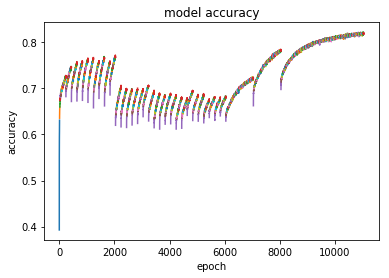

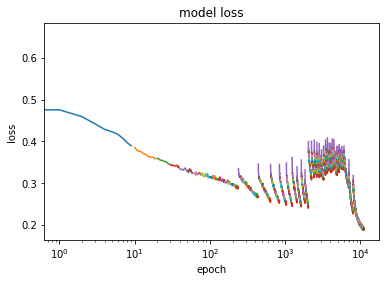

In [231]:
figure()
#print(history3.history.keys())
#plot(history.history['acc'])
#plot(history3.history['acc'])
for i in range(ih):
    plot(arange(10)+i*10,history[i].history['MOC'])

title('model accuracy')
ylabel('accuracy')
xlabel('epoch')
figure()
#plot(history.history['loss'])
#plot(history3.history['loss'])
for i in range(ih):
    plot(arange(10)+i*10,history[i].history['loss'])

title('model loss')
ylabel('loss')
xlabel('epoch')
#yscale("log")
xscale("log")

In [232]:
loss, acc = model.evaluate(Xdev, Ydev)
print("Dev set accuracy = ", acc)

100/100 [==============================] - 1s 6ms/step
Dev set accuracy =  0.7303757882118225


In [254]:
def MOCv(y_true,y_pred):
    '''Just another crossentropy'''
    ly =sum(y_true*y_pred)
    ly2 = sum(y_pred*y_pred)
    ly2l = 1.0*(ly2==0)
    ly2 = ly2+ly2l
    ly3 = sum(y_true*y_true)
    ly3l = 1.0*(ly3==0)
    ly3 = ly3+ly3l
    out = ly/sqrt(ly2*ly3) 
    return out+1.0*ly2l*ly3l
def PCCv(y_true,y_pred):
    '''Just another crossentropy'''
    lt1 = y_true-mean(y_true)
    lt2 = y_pred-mean(y_pred)
    
    ly = sum(lt1*lt2)
    ly2 = sum(lt1*lt1)
    ly3 =sum(lt2*lt2)
    out = ly/sqrt(ly2*ly3)
    
    return out

(1, 20, 20, 500, 1)
(1, 20, 20, 1, 1)
MOC of prediction, sum =  0.946255943196934 0.29208386354452626
PCC of prediction, sum =  0.9427299533113491 0.6869358373061192
CPU times: user 71.3 ms, sys: 0 ns, total: 71.3 ms
Wall time: 66.3 ms


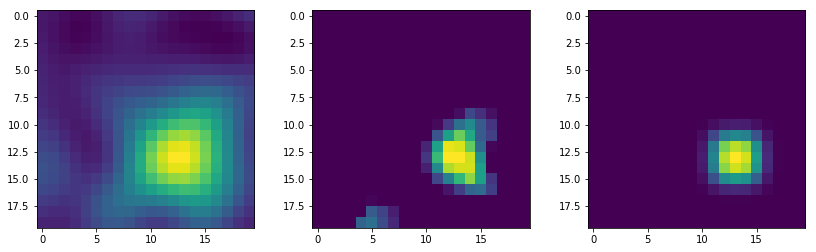

In [346]:
%%time
figure(figsize=(14,4))
i = 500+randint(100)
a = load(datadir+"d4"+str(i).zfill(4)+".npy");
b = load(datadir+"o4_"+str(i).zfill(4)+".npy");
subplot(1, 3, 3)

start = 0
end = 500
xt = a[:,:,start:end]
xt = xt/mean(xt.flatten())
ix = randint(20)
iy = randint(20)
xt = xt[ix:(ix+magn*width),iy:(iy+magn*height),:]
b = b[ix:(ix+magn*width),iy:(iy+magn*height)]
imshow(b)

#xt = ftvaugment(xt,magn)
xt = reshape(xt,(1,magn*width,magn*height,500,1))

xt = reshape(xt,(1,magn*width,magn*height,500,1))
print(xt.shape)
y = model.predict(xt)
print(y.shape)
#print(squeeze(y).shape)
subplot(1, 3, 2)
imshow(squeeze(y))
subplot(1, 3, 1)
imshow(sum(xt[0,:,:,:,0],axis=-1))
print("MOC of prediction, sum = ",MOCv(b,squeeze(y)),MOCv(sum(squeeze(xt[:,:,:,:,:]),axis=-1),b))
print("PCC of prediction, sum = ",PCCv(b,squeeze(y)),PCCv(sum(squeeze(xt[:,:,:,:,:]),axis=-1),b))


In [290]:
print("MOC of prediction = ",MOCv(b,squeeze(y)))
print("MOC of sum = ",MOCv(sum(xt[0,:,:,:,0],axis=-1),b))

MOC of prediction =  0.0
MOC of sum =  0.12090159133403891


In [94]:
maxb = []
for i in range(900):
    b = load(datadir+"o2_"+str(i).zfill(4)+".npy");
    maxb.append(max(b.flatten()))

In [184]:
sum(array(maxb)<1e-3)/900


0.11333333333333333

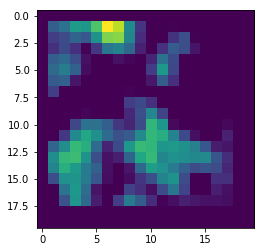

In [50]:
imshow(squeeze(y),vmin= 1.21)

In [216]:
model.save("deepsofi_x4_20180927.h5")
